**Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code and solutions to the exercises in chapter 15._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
from IPython.core.interactiveshell import InteractiveShell # make all output in ipython show, not just last line
InteractiveShell.ast_node_interactivity = "all"   # pretty print all cell's output and not just the last one
%matplotlib inline

import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/rnn` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Basic RNNs

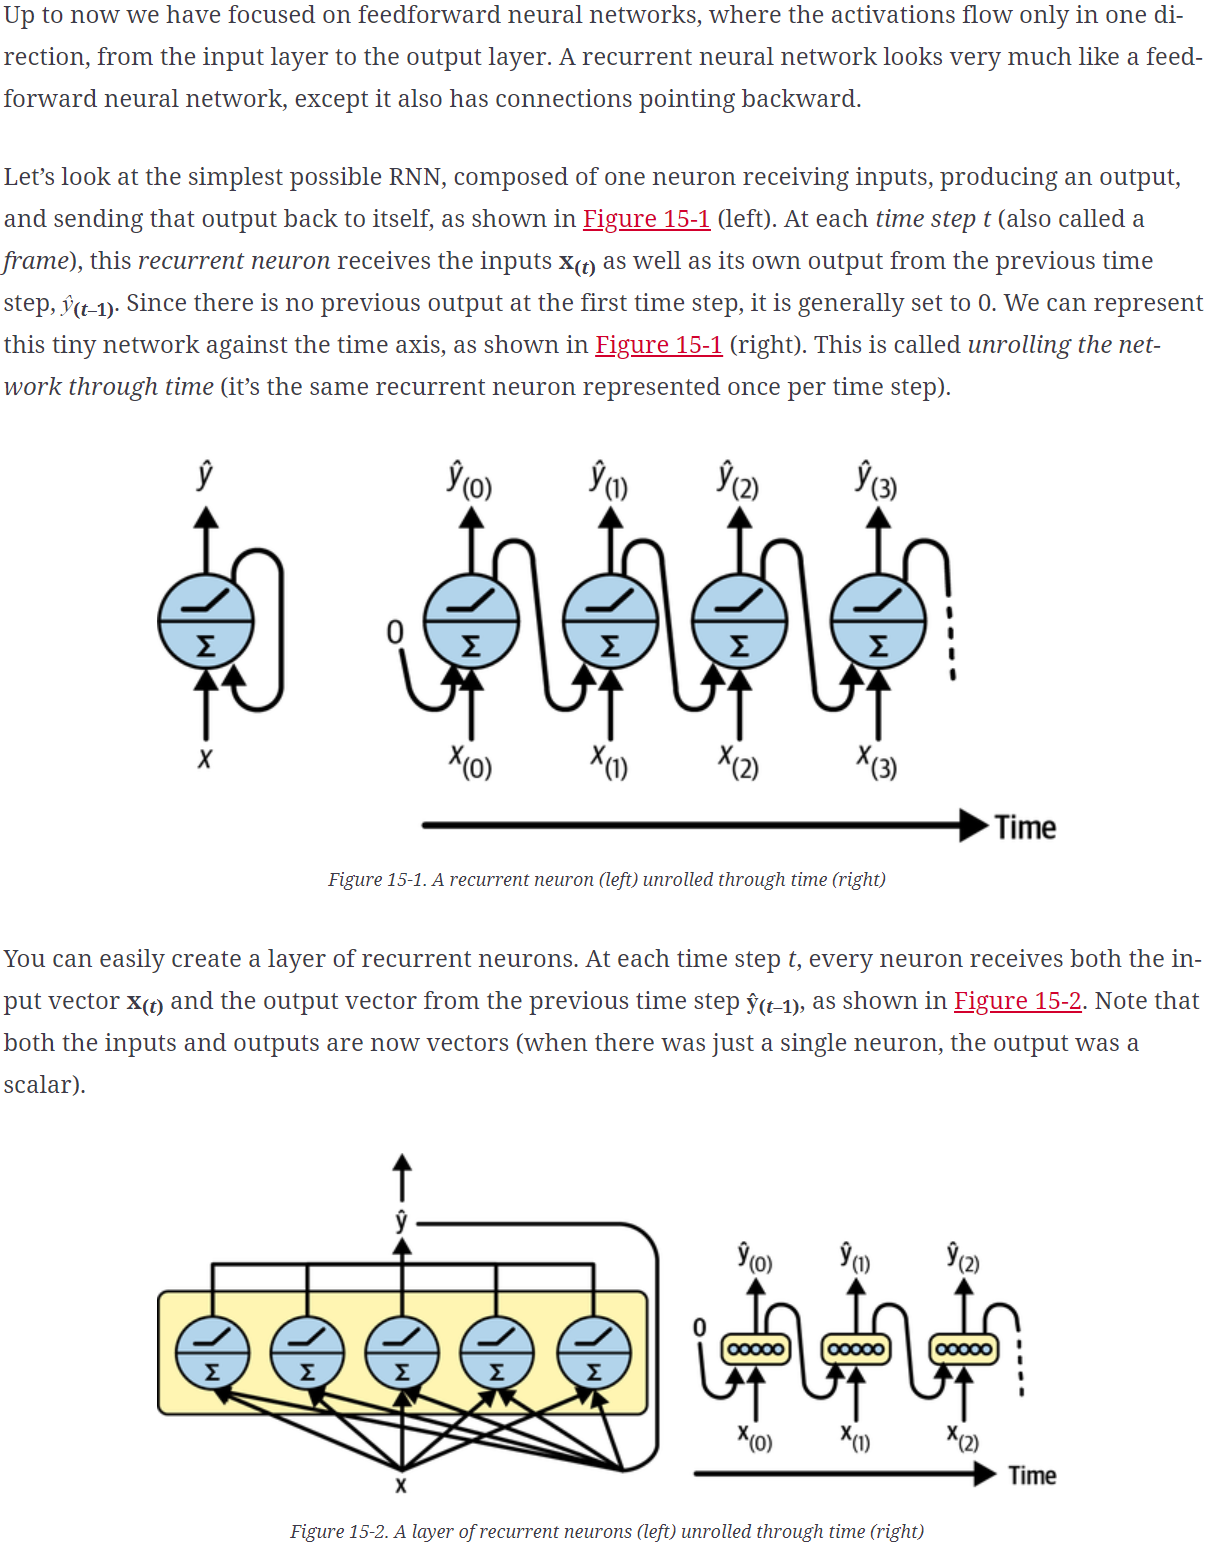
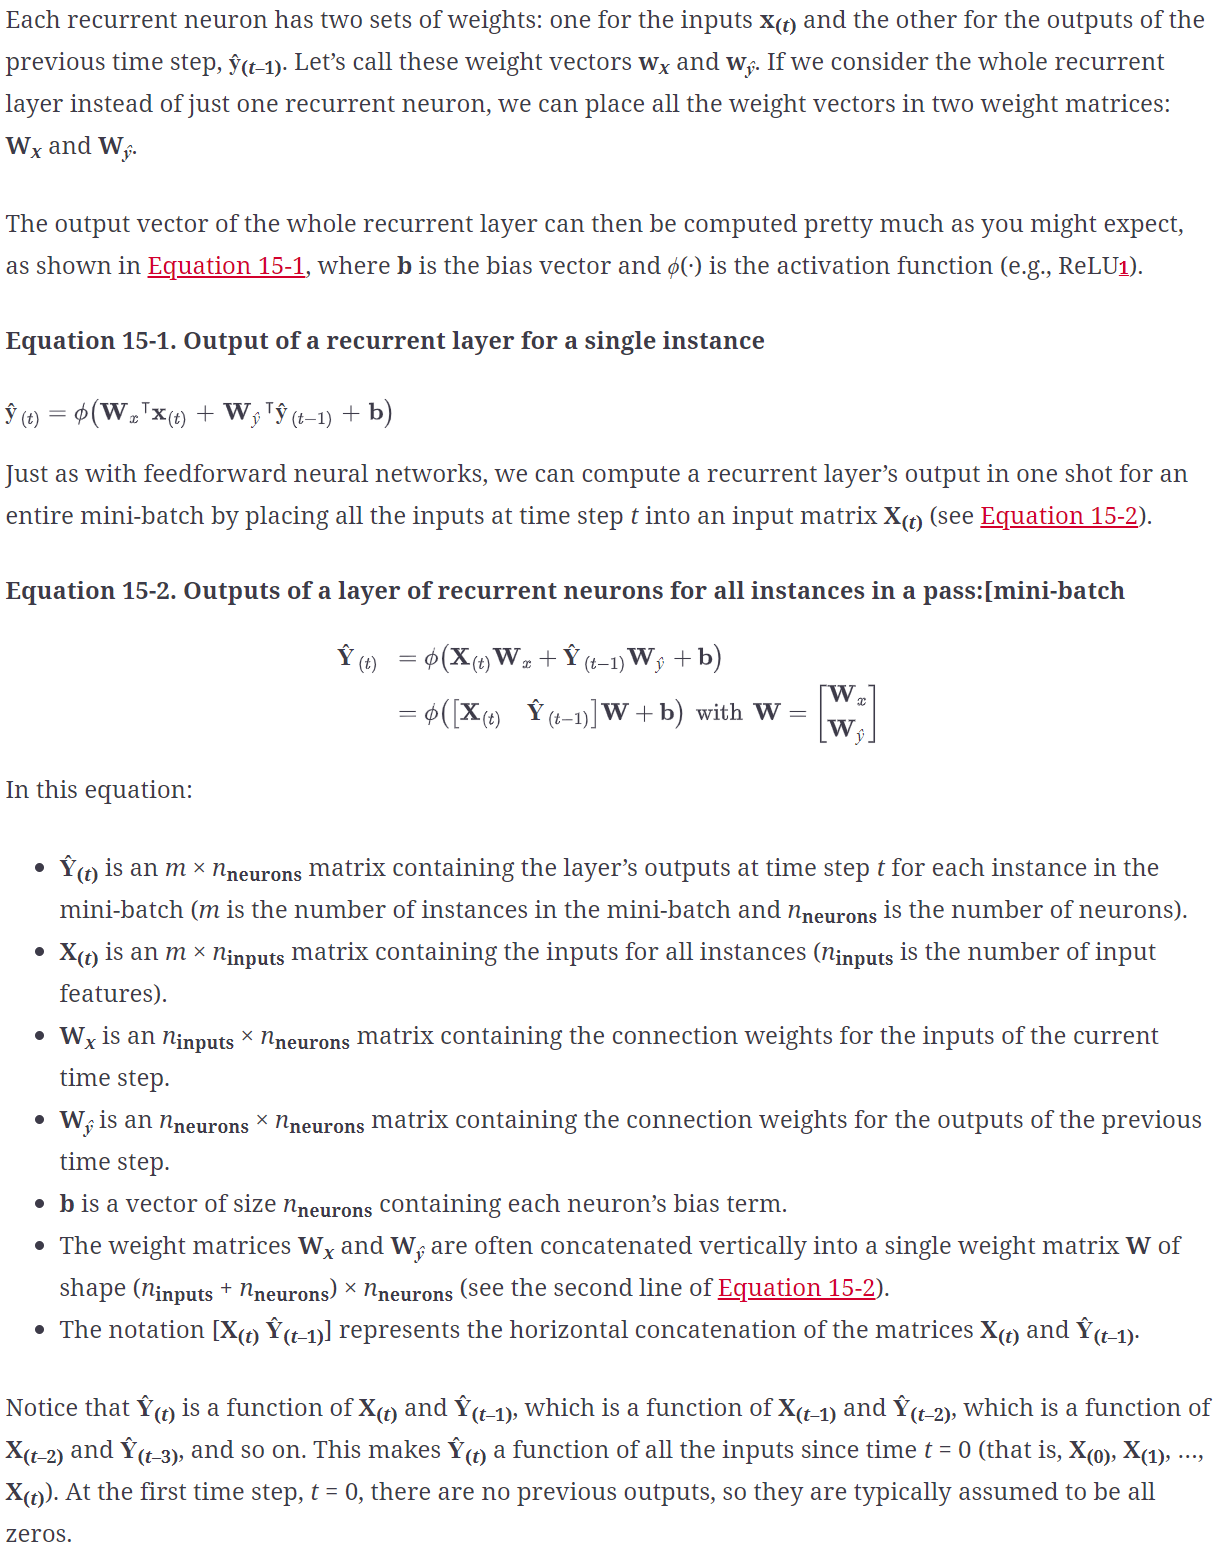
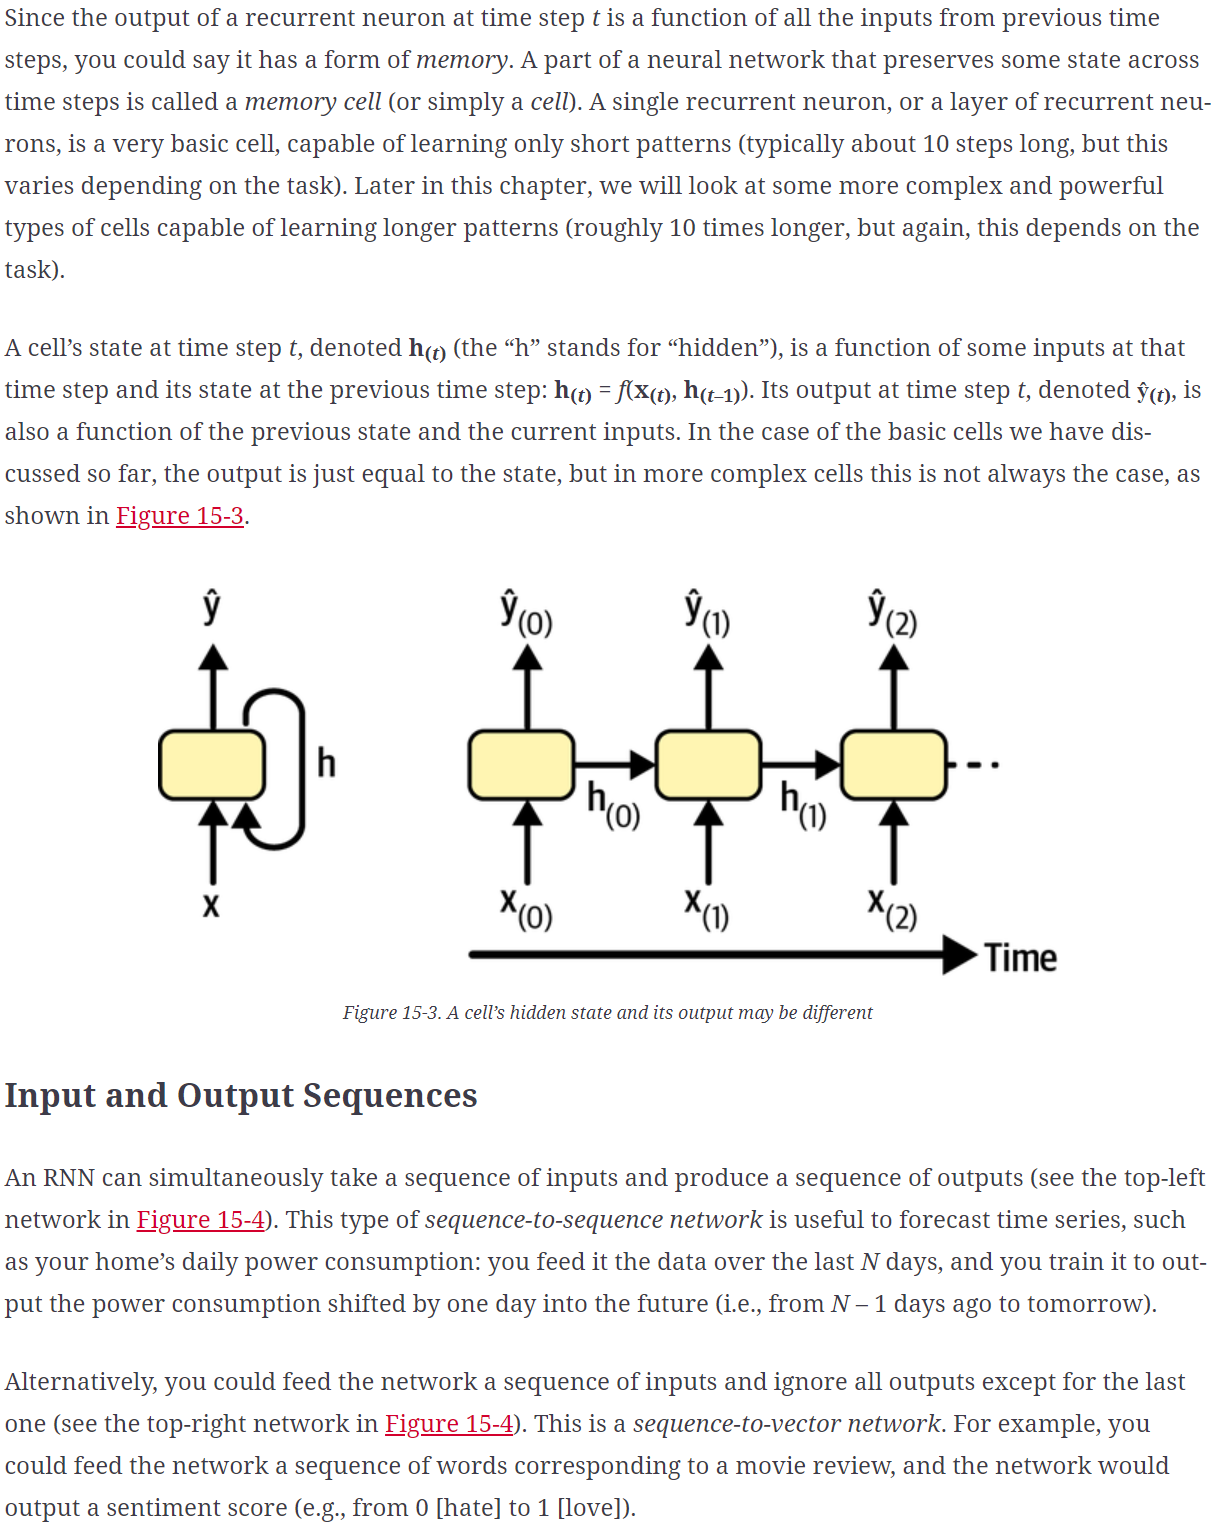
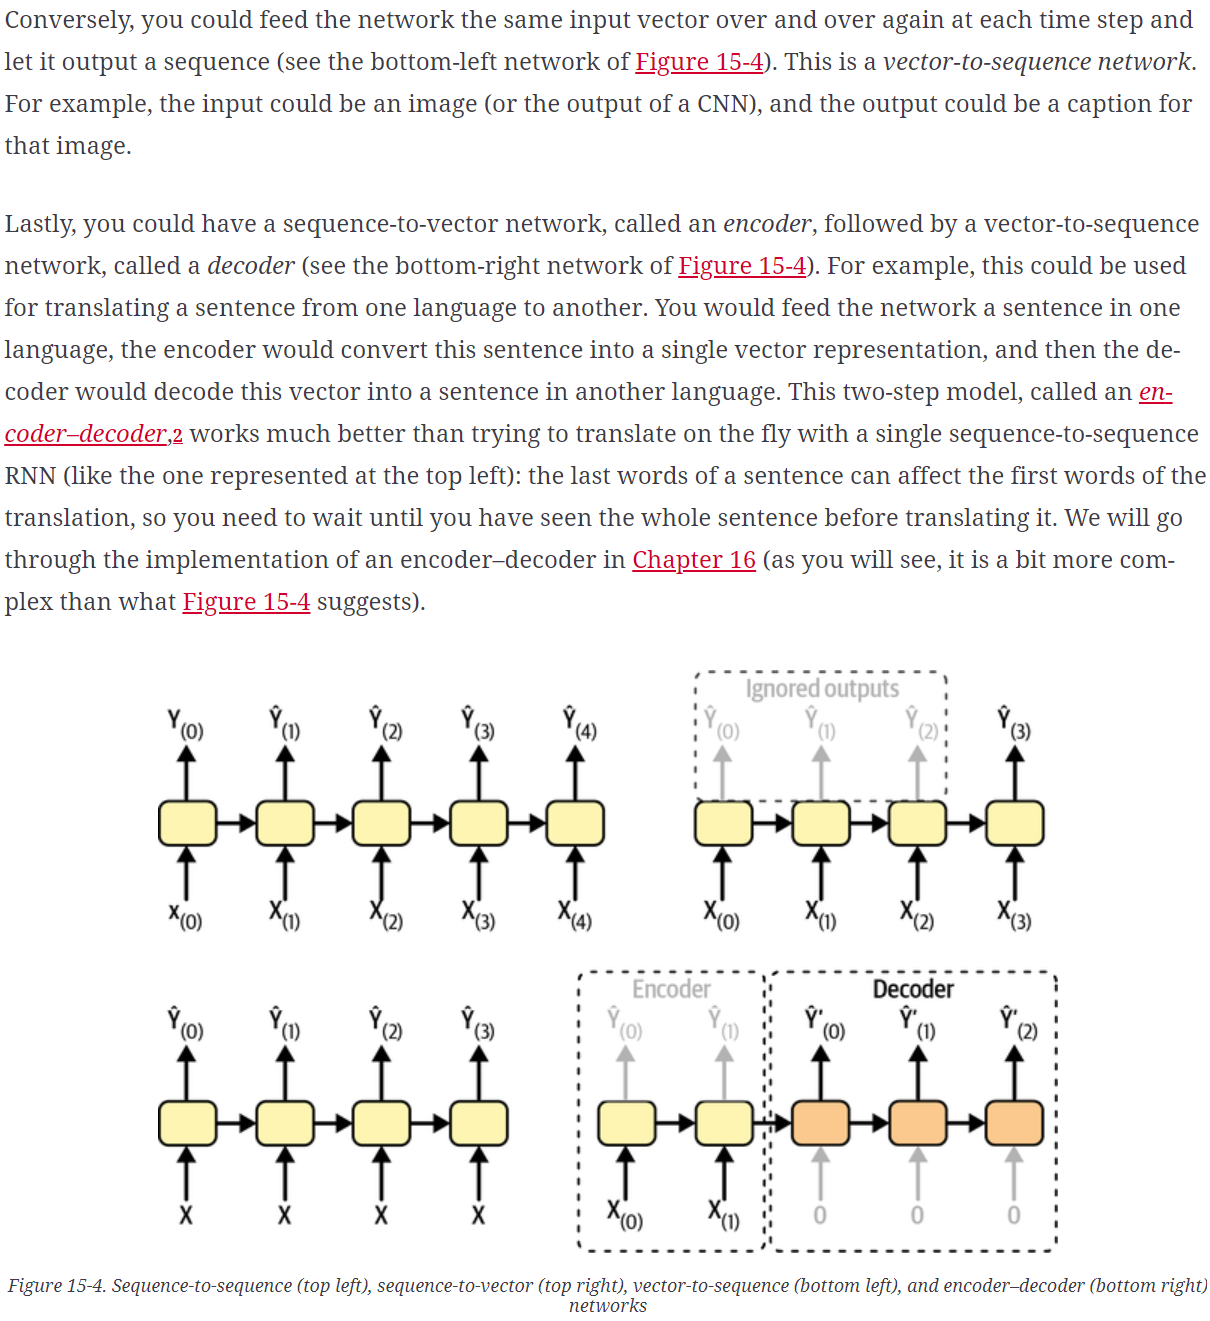
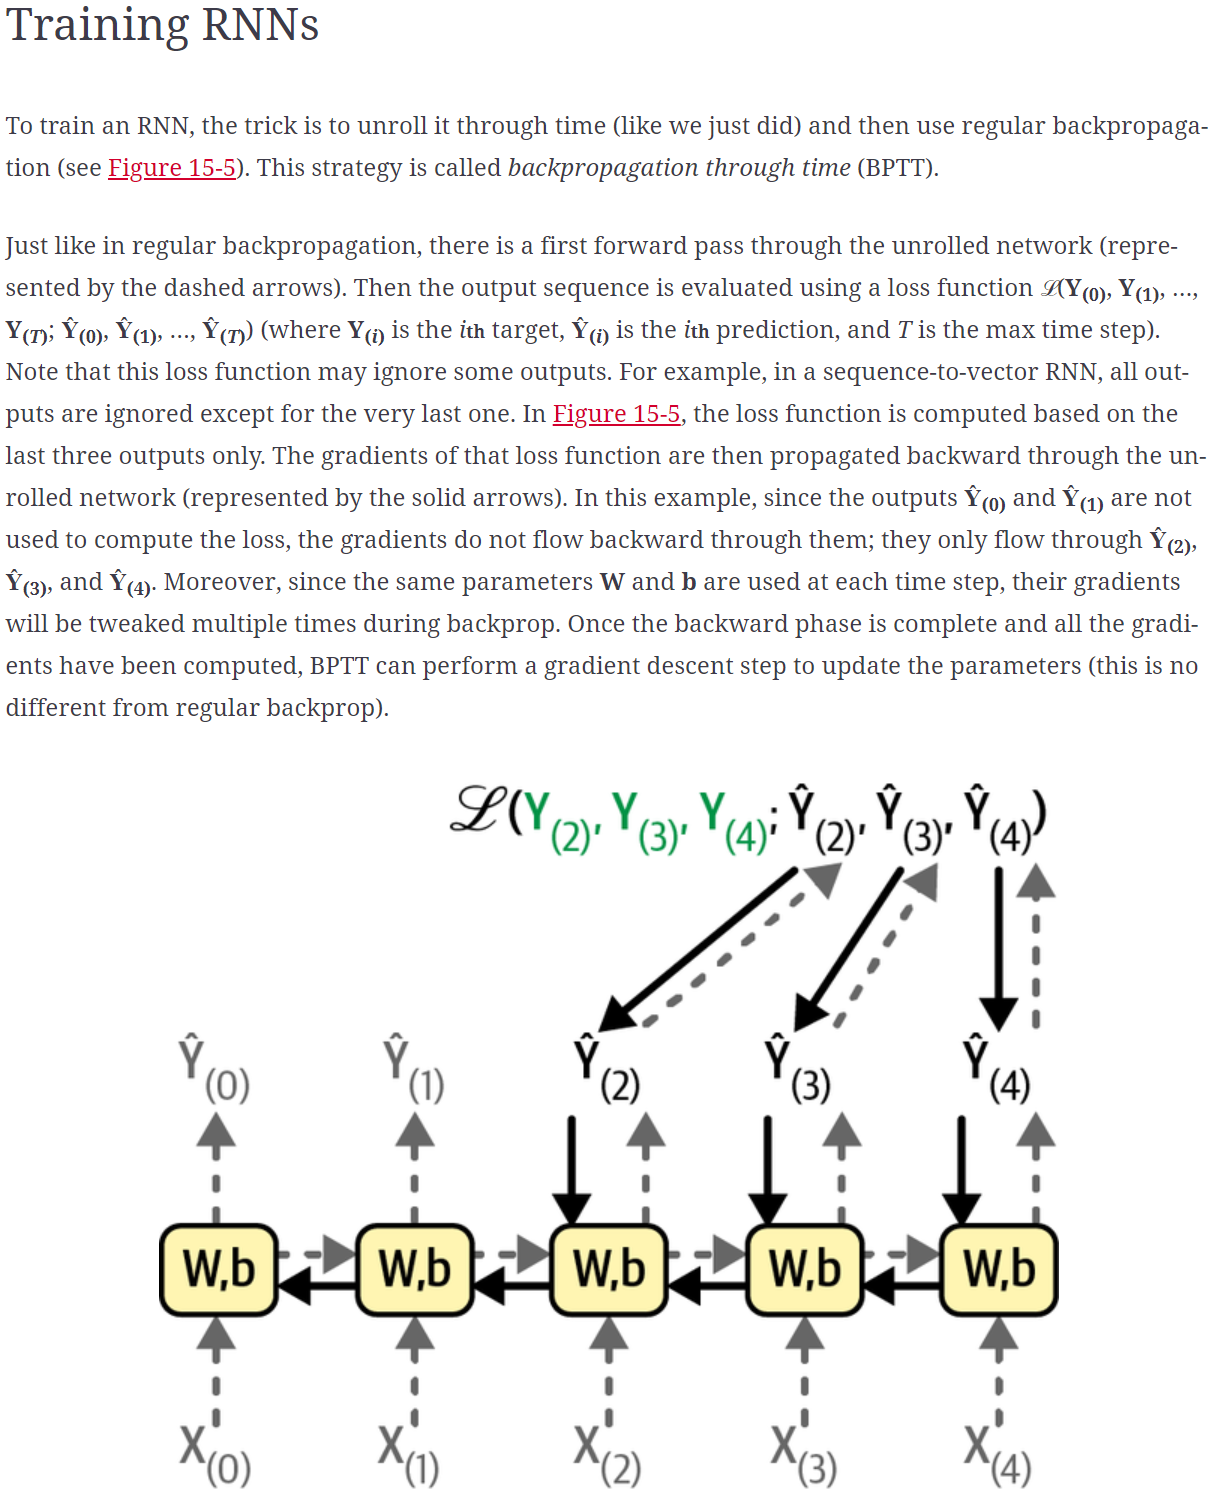

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [6]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'.\\datasets\\ridership.tgz'

In [7]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [8]:
df.head()

day_type     bus    rail
date                               
2001-01-01        U  297192  126455
2001-01-02        W  780827  501952
2001-01-03        W  824923  536432
2001-01-04        W  870021  550011
2001-01-05        W  890426  557917

The day_type column contains W for Weekdays, A for Saturdays, and U for Sundays or holidays.

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

<AxesSubplot:xlabel='date'>

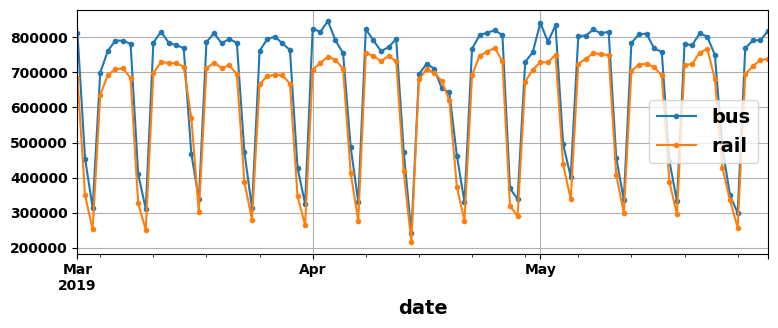

In [9]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

(170000.0, 900000.0)

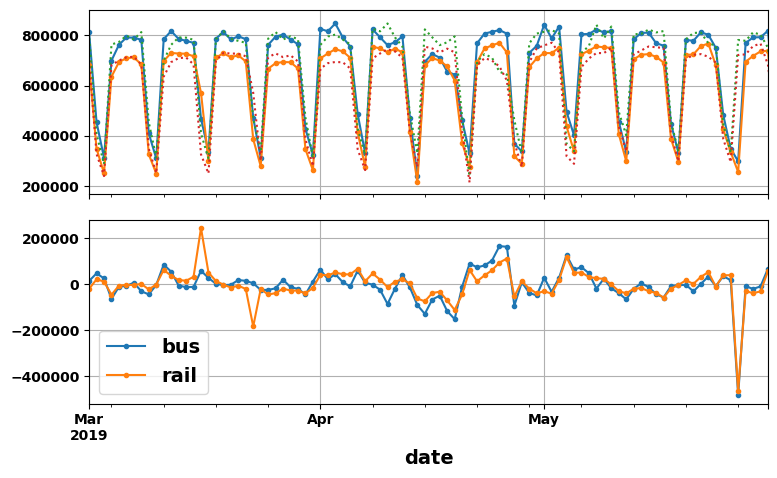

In [10]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

Above plot shows the difference between the current day and the value from 7 days earlier.  Since the time series has weekly periodicity, this shows any trends outside the daily trend.

In [11]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [12]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Our naive forecasts get an MAE of about 43,916 bus riders, and about 42,143 rail riders. It’s hard to tell at a glance how good or bad this is, so let’s put the forecast errors into perspective by dividing them by the target values:
It looks like our naive forecasts give us a MAPE of roughly 8.3% for bus and 9.0% for rail. 
Mean absolute percentage error (MAPE):

In [13]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

Now let's look at the yearly seasonality and the long-term trends:

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

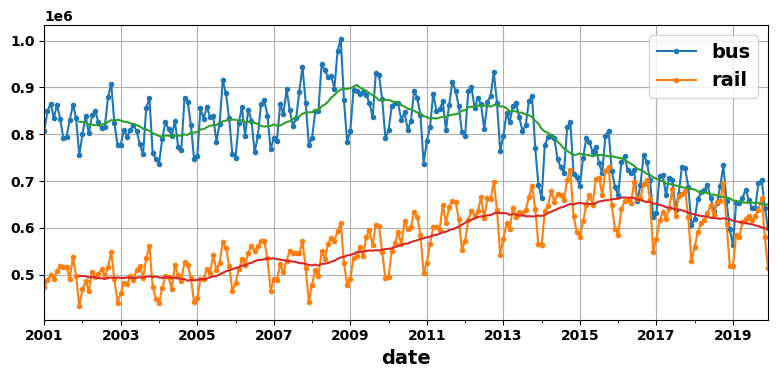

In [14]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

Above shows the mean value of daily ridership for each month (points) and a 12 month moving average (line).

<AxesSubplot:xlabel='date'>

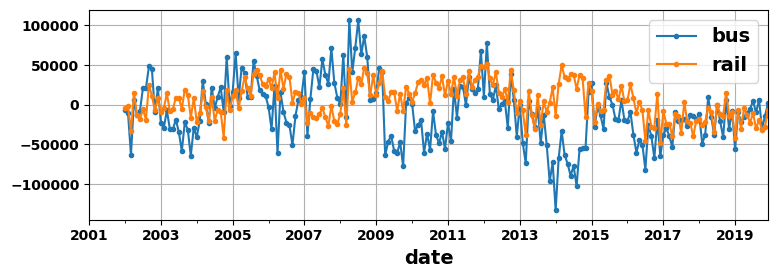

In [15]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

The above plot shows the difference between the current month and the value from 12 months ago (diff plot).

If running on Colab or Kaggle, install the statsmodels library:

In [16]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

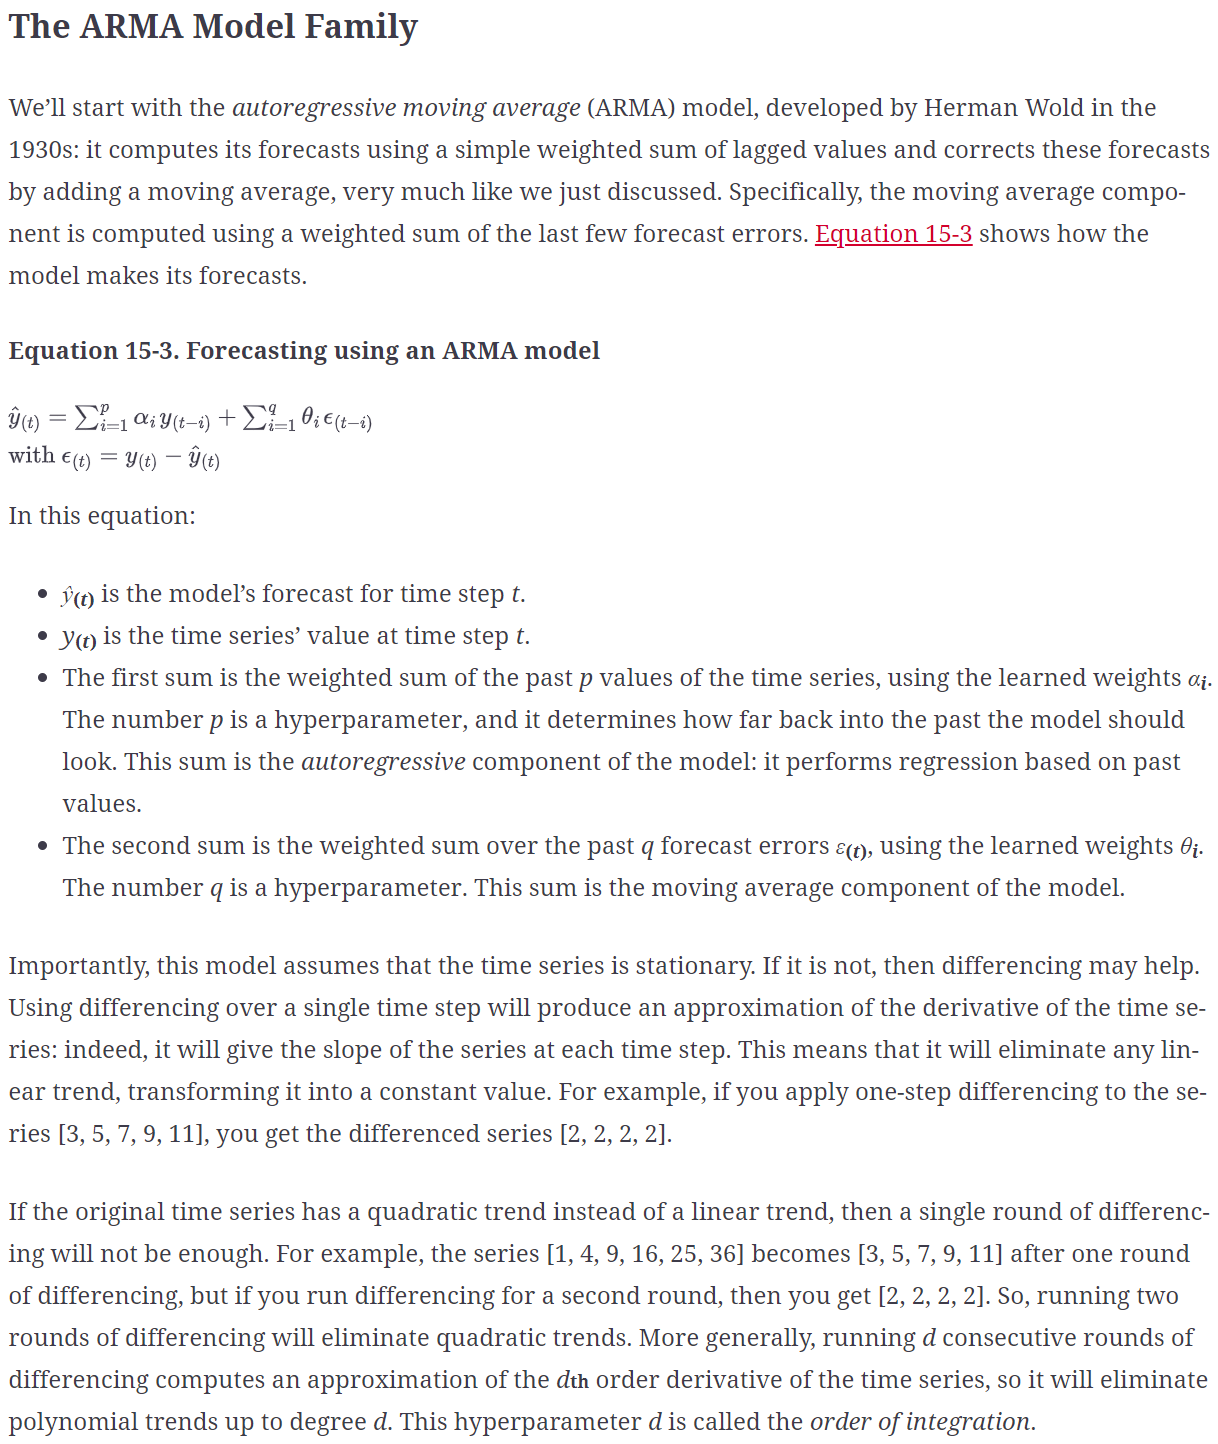
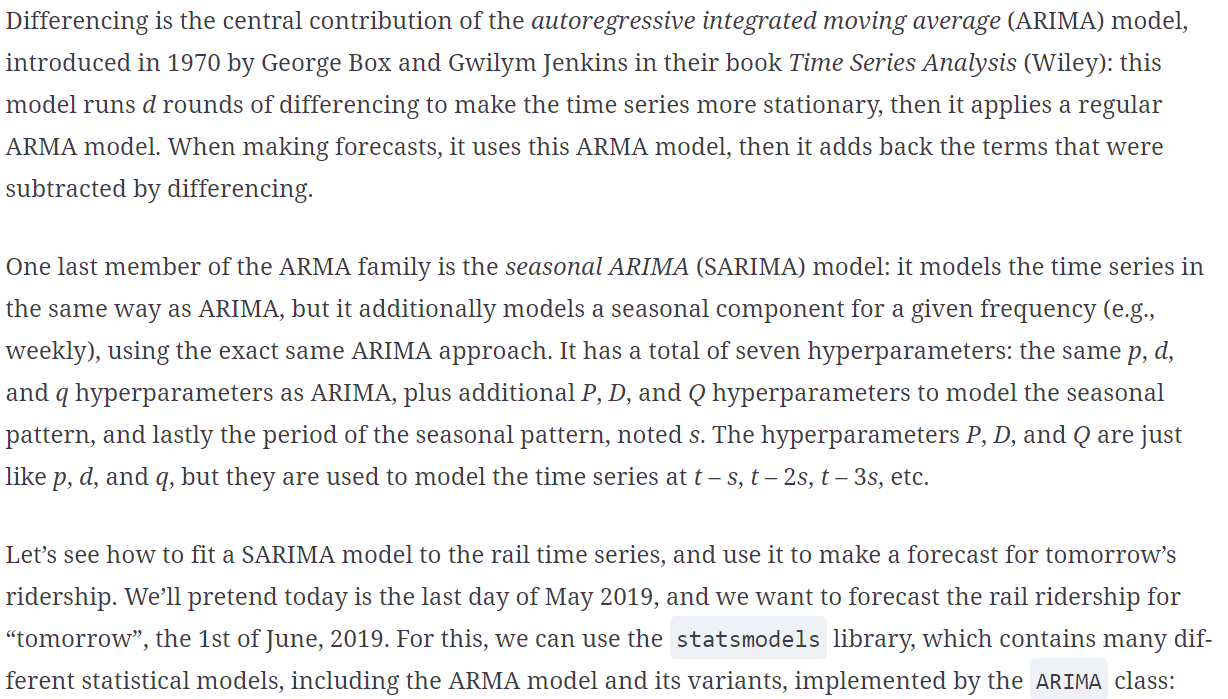

Create an ARIMA (Autoregressive Integrated Moving Average) model.  The model uses data from Jan 1 to May 31, 2019.

We start by importing the ARIMA class, then we take the rail ridership data from the start of 2019 up to “today”, and we use asfreq("D") to set the time series’ frequency to daily: this doesn’t change the data at all in this case, since it’s already daily, but without this the ARIMA class would have to guess the frequency, and it would display a warning.

Next, we create an ARIMA instance, passing it all the data until “today”, and we set the model hyperparameters: order=(1, 0, 0) means that p = 1, d = 0, q = 0, and seasonal_order=(0, 1, 1, 7) means that P = 0, D = 1, Q = 1, and s = 7. Notice that the statsmodels API differs a bit from Scikit-Learn’s API, since we pass the data to the model at construction time, instead of passing it to the fit() method.

p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.

Next, we fit the model, and we use it to make a forecast for “tomorrow”, the 1st of June, 2019.

In [17]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [18]:
y_pred[0]  # ARIMA forecast

427758.62626729626

In [19]:
df["rail"].loc["2019-06-01"]  # target value - the actual value we were trying to predict

379044

In [20]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

Run a for loop to predict the next day traffic.  Append the predictions to a list and then compute MAE.

In [21]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

Create a running one day out prediction from March 1 to May 31.  Then compare to actual to get MAE.

In [22]:
mae

32040.720087447182

Mean Absolute Error is averaging 32042 vs the one time prediction we did above with a MAE of 427758.62 - 379044 = 48,714

Seasonal AutoRegressive Integrated Moving Average plots of true vs forecast

<AxesSubplot:>

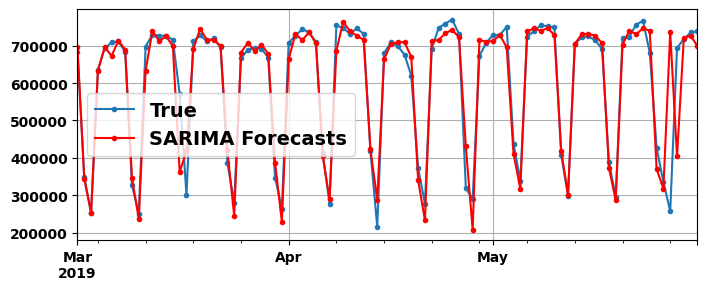

In [23]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

How to tune parameters:

https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

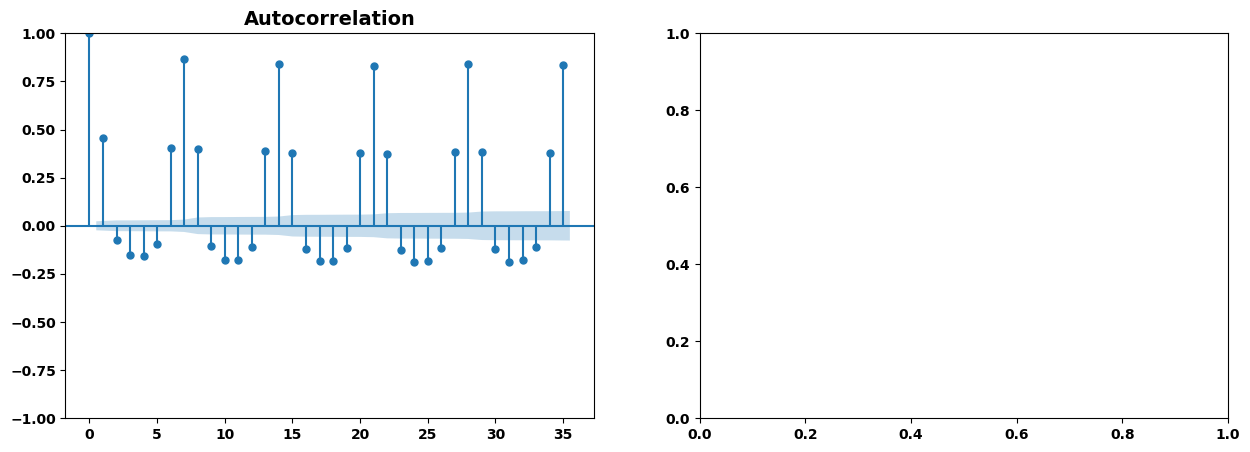

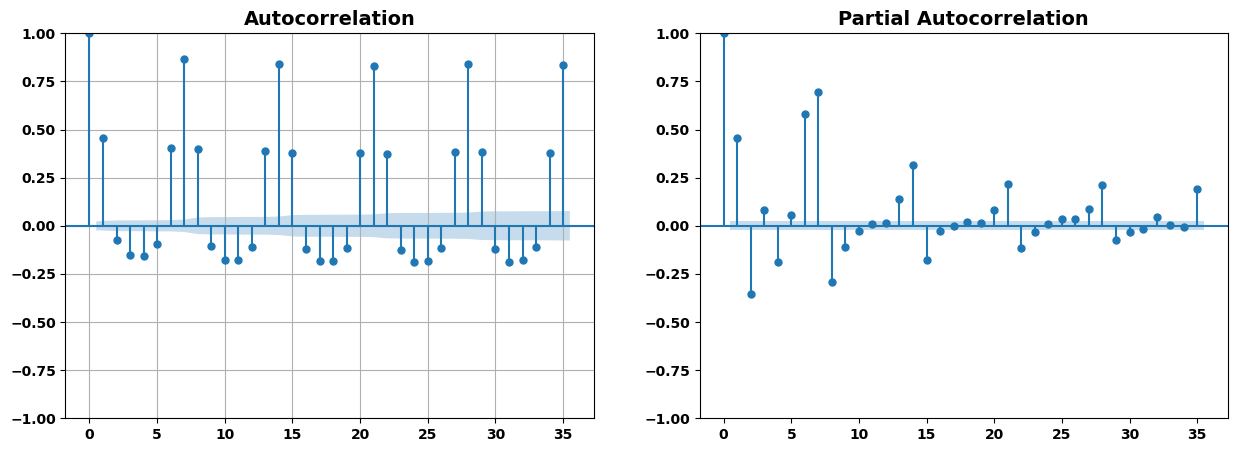

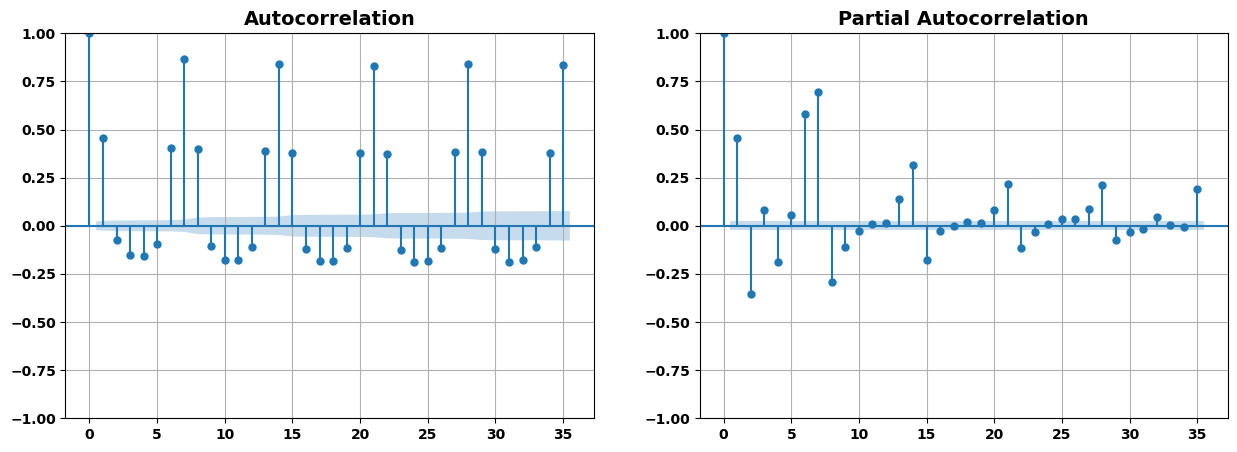

In [24]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

Correlation and Autocorrelation
Statistical correlation summarizes the strength of the relationship between two variables.

We can assume the distribution of each variable fits a Gaussian (bell curve) distribution. If this is the case, we can use the Pearson’s correlation coefficient to summarize the correlation between the variables.

The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

— Page 81, Section 4.5.6 Partial Autocorrelations, Introductory Time Series with R.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

### Prepare data for ML models

Now that we have two baselines, naive forecasting and SARIMA, let’s try to use the machine learning models we’ve covered so far to forecast this time series, starting with a basic linear model. Our goal will be to forecast tomorrow’s ridership based on the ridership of the past 8 weeks of data (56 days). The inputs to our model will therefore be sequences (usually a single sequence per day once the model is in production), each containing 56 values from time steps t – 55 to t. For each input sequence, the model will output a single value: the forecast for time step t + 1.

But what will we use as training data? Well, that’s the trick: we will use every 56-day window from the past as training data, and the target for each window will be the value immediately following it.

Keras actually has a nice utility function called tf.keras.utils.timeseries_​data⁠set_from_array() to help us prepare the training set. It takes a time series as input, and it builds a tf.data.Dataset (introduced in Chapter 13) containing all the windows of the desired length, as well as their corresponding targets. Here’s an example that takes a time series containing the numbers 0 to 5 and creates a dataset containing all the windows of length 3, with their corresponding targets, grouped into batches of size 2:

In [25]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

Each sample in the dataset is a window of length 3, along with its corresponding target (i.e., the value immediately after the window). The windows are [0, 1, 2], [1, 2, 3], and [2, 3, 4], and their respective targets are 3, 4, and 5. Since there are three windows in total, which is not a multiple of the batch size, the last batch only contains one window instead of two.

Another way to get the same result is to use the window() method of tf.data’s Dataset class. It’s more complex, but it gives you full control, which will come in handy later in this chapter, so let’s see how it works. The window() method returns a dataset of window datasets:

In [26]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In this example, the dataset contains six windows, each shifted by one step compared to the previous one, and the last three windows are smaller because they’ve reached the end of the series. In general you’ll want to get rid of these smaller windows by passing drop_remainder=True to the window() method.

In [27]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


The window() method returns a nested dataset, analogous to a list of lists. This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, we cannot use a nested dataset directly for training, as our model will expect tensors as input, not datasets.

Therefore, we must call the flat_map() method: it converts a nested dataset into a flat dataset (one that contains tensors, not datasets). For example, suppose {1, 2, 3} represents a dataset containing the sequence of tensors 1, 2, and 3. If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}}, you get back the flat dataset {1, 2, 3, 4, 5, 6}.

Moreover, the flat_map() method takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening. For example, if you pass the function lambda ds: ds.batch(2) to flat_map(), then it will transform the nested dataset {{1, 2}, {3, 4, 5, 6}} into the flat dataset {[1, 2], [3, 4], [5, 6]}: it’s a dataset containing 3 tensors, each of size 2.

In [28]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

The last step is to split each window into inputs and targets, using the map() method. We can also group the resulting windows into batches of size 2:

In [29]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [30]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Next, let’s use timeseries_dataset_from_array() to create datasets for training and validation. Since gradient descent expects the instances in the training set to be independent and identically distributed (IID), as we saw in Chapter 4, we must set the argument shuffle=True to shuffle the training windows (but not their contents):

In [31]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

Let’s try a basic linear model first. We will use the Huber loss, which usually works better than minimizing the MAE directly, as discussed in Chapter 10. We’ll also use early stopping:

In [32]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 2s 16ms/step - loss: 0.0208 - mae: 0.1527 - val_loss: 0.0081 - val_mae: 0.0981
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0102 - mae: 0.1113 - val_loss: 0.0086 - val_mae: 0.1048
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0085 - mae: 0.0998 - val_loss: 0.0058 - val_mae: 0.0810
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0066 - mae: 0.0855 - val_loss: 0.0073 - val_mae: 0.0973
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0063 - mae: 0.0826 - val_loss: 0.0053 - val_mae: 0.0770
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0055 - mae: 0.0768 - val_loss: 0.0046 - val_mae: 0.0685
Epoch 7/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0052 - mae: 0.0748 - val_loss: 0.0049 - val_mae: 0.0727
Epoch 8/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0050 

Epoch 63/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0027 - mae: 0.0454 - val_loss: 0.0023 - val_mae: 0.0399
Epoch 64/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0027 - mae: 0.0464 - val_loss: 0.0025 - val_mae: 0.0416
Epoch 65/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0031 - mae: 0.0548 - val_loss: 0.0023 - val_mae: 0.0420
Epoch 66/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0028 - mae: 0.0460 - val_loss: 0.0023 - val_mae: 0.0419
Epoch 67/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0028 - mae: 0.0484 - val_loss: 0.0023 - val_mae: 0.0402
Epoch 68/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0028 - mae: 0.0467 - val_loss: 0.0024 - val_mae: 0.0407
Epoch 69/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0027 - mae: 0.0464 - val_loss: 0.0033 - val_mae: 0.0564
Epoch 70/500
33/33 [==============================] - 0s 13ms/step - 

33/33 [==============================] - 0s 9ms/step - loss: 0.0026 - mae: 0.0439 - val_loss: 0.0029 - val_mae: 0.0478
Epoch 125/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0028 - mae: 0.0494 - val_loss: 0.0024 - val_mae: 0.0434
Epoch 126/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0032 - mae: 0.0553 - val_loss: 0.0031 - val_mae: 0.0522
Epoch 127/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0027 - mae: 0.0467 - val_loss: 0.0031 - val_mae: 0.0526
Epoch 128/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0029 - mae: 0.0498 - val_loss: 0.0023 - val_mae: 0.0401
Epoch 129/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0025 - mae: 0.0421 - val_loss: 0.0022 - val_mae: 0.0379
Epoch 130/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0026 - mae: 0.0432 - val_loss: 0.0023 - val_mae: 0.0407
Epoch 131/500
33/33 [==============================] - 0s 10ms/step - loss: 0.002

In [33]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 6ms/step - loss: 0.0022 - mae: 0.0377


37684.07553434372

Better than naive forecasting, but worse than the SARIMA model

## Using a Simple RNN

Let’s try the most basic RNN, containing a single recurrent layer with just one recurrent neuron

All recurrent layers in Keras expect 3D inputs of shape [batch size, time steps, dimensionality], where dimensionality is 1 for univariate time series and more for multivariate time series. Recall that the input_shape argument ignores the first dimension (i.e., the batch size), and since recurrent layers can accept input sequences of any length, we can set the second dimension to None, which means “any size”. Lastly, since we’re dealing with a univariate time series, we need the last dimension’s size to be 1. This is why we specified the input shape [None, 1]: it means “univariate sequences of any length”. Note that the datasets actually contain inputs of shape [batch size, time steps], so we’re missing the last dimension, of size 1, but Keras is kind enough to add it for us in this case.

This model works exactly as we saw earlier: the initial state h(init) is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, x(0). The neuron computes a weighted sum of these values plus the bias term, and it applies the activation function to the result, using the hyperbolic tangent function by default. The result is the first output, y0. In a simple RNN, this output is also the new state h0. This new state is passed to the same recurrent neuron along with the next input value, x(1), and the process is repeated until the last time step. At the end, the layer just outputs the last value: in our case the sequences are 56 steps long, so the last value is y55. All of this is performed simultaneously for every sequence in the batch, of which there are 32 in this case.

By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set return_sequences=True, as you will see.

In [34]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [35]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [36]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 5s 117ms/step - loss: 0.0696 - mae: 0.3064 - val_loss: 0.0145 - val_mae: 0.1164
Epoch 2/500
33/33 [==============================] - 3s 98ms/step - loss: 0.0139 - mae: 0.1267 - val_loss: 0.0128 - val_mae: 0.1199
Epoch 3/500
33/33 [==============================] - 3s 98ms/step - loss: 0.0125 - mae: 0.1393 - val_loss: 0.0122 - val_mae: 0.1275
Epoch 4/500
33/33 [==============================] - 3s 95ms/step - loss: 0.0123 - mae: 0.1378 - val_loss: 0.0122 - val_mae: 0.1239
Epoch 5/500
33/33 [==============================] - 3s 103ms/step - loss: 0.0123 - mae: 0.1362 - val_loss: 0.0122 - val_mae: 0.1237
Epoch 6/500
33/33 [==============================] - 3s 94ms/step - loss: 0.0122 - mae: 0.1363 - val_loss: 0.0121 - val_mae: 0.1231
Epoch 7/500
33/33 [==============================] - 3s 88ms/step - loss: 0.0122 - mae: 0.1361 - val_loss: 0.0120 - val_mae: 0.1228
Epoch 8/500
33/33 [==============================] - 3s 92ms/step - loss: 

33/33 [==============================] - 4s 123ms/step - loss: 0.0104 - mae: 0.1164 - val_loss: 0.0103 - val_mae: 0.1068
Epoch 63/500
33/33 [==============================] - 4s 127ms/step - loss: 0.0104 - mae: 0.1162 - val_loss: 0.0103 - val_mae: 0.1064
Epoch 64/500
33/33 [==============================] - 3s 94ms/step - loss: 0.0104 - mae: 0.1159 - val_loss: 0.0103 - val_mae: 0.1063
Epoch 65/500
33/33 [==============================] - 4s 107ms/step - loss: 0.0104 - mae: 0.1158 - val_loss: 0.0103 - val_mae: 0.1062
Epoch 66/500
33/33 [==============================] - 3s 97ms/step - loss: 0.0104 - mae: 0.1160 - val_loss: 0.0103 - val_mae: 0.1060
Epoch 67/500
33/33 [==============================] - 4s 108ms/step - loss: 0.0104 - mae: 0.1157 - val_loss: 0.0103 - val_mae: 0.1057
Epoch 68/500
33/33 [==============================] - 3s 99ms/step - loss: 0.0104 - mae: 0.1154 - val_loss: 0.0103 - val_mae: 0.1057
Epoch 69/500
33/33 [==============================] - 3s 99ms/step - loss: 0.0

33/33 [==============================] - 3s 96ms/step - loss: 0.0103 - mae: 0.1133 - val_loss: 0.0103 - val_mae: 0.1031
Epoch 124/500
33/33 [==============================] - 3s 97ms/step - loss: 0.0104 - mae: 0.1133 - val_loss: 0.0102 - val_mae: 0.1031
Epoch 125/500
33/33 [==============================] - 3s 90ms/step - loss: 0.0103 - mae: 0.1131 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 126/500
33/33 [==============================] - 3s 90ms/step - loss: 0.0103 - mae: 0.1132 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 127/500
33/33 [==============================] - 3s 89ms/step - loss: 0.0104 - mae: 0.1133 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 128/500
33/33 [==============================] - 3s 103ms/step - loss: 0.0103 - mae: 0.1130 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 129/500
33/33 [==============================] - 4s 112ms/step - loss: 0.0104 - mae: 0.1134 - val_loss: 0.0102 - val_mae: 0.1032
Epoch 130/500
33/33 [==============================] - 3s 95ms/step - loss

33/33 [==============================] - 3s 93ms/step - loss: 0.0104 - mae: 0.1129 - val_loss: 0.0102 - val_mae: 0.1030
Epoch 185/500
33/33 [==============================] - 3s 96ms/step - loss: 0.0103 - mae: 0.1132 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 186/500
33/33 [==============================] - 4s 107ms/step - loss: 0.0103 - mae: 0.1132 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 187/500
33/33 [==============================] - 3s 93ms/step - loss: 0.0104 - mae: 0.1132 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 188/500
33/33 [==============================] - 3s 93ms/step - loss: 0.0103 - mae: 0.1129 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 189/500
33/33 [==============================] - 3s 91ms/step - loss: 0.0103 - mae: 0.1127 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 190/500
33/33 [==============================] - 4s 117ms/step - loss: 0.0104 - mae: 0.1132 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 191/500
33/33 [==============================] - 4s 115ms/step - los

Epoch 245/500
33/33 [==============================] - 4s 119ms/step - loss: 0.0104 - mae: 0.1132 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 246/500
33/33 [==============================] - 4s 108ms/step - loss: 0.0104 - mae: 0.1129 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 247/500
33/33 [==============================] - 5s 137ms/step - loss: 0.0104 - mae: 0.1131 - val_loss: 0.0102 - val_mae: 0.1030
Epoch 248/500
33/33 [==============================] - 4s 130ms/step - loss: 0.0103 - mae: 0.1130 - val_loss: 0.0103 - val_mae: 0.1028
Epoch 249/500
33/33 [==============================] - 4s 105ms/step - loss: 0.0103 - mae: 0.1127 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 250/500
33/33 [==============================] - 3s 103ms/step - loss: 0.0103 - mae: 0.1132 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 251/500
33/33 [==============================] - 5s 141ms/step - loss: 0.0104 - mae: 0.1131 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 252/500
33/33 [==============================] - 

102775.85685253143

Now if you compile, train, and evaluate this model just like the previous model, you will find that it’s no good at all: its validation MAE is greater than 100,000! Ouch. That was to be expected, for two reasons:

The model only has a single recurrent neuron, so the only data it can use to make a prediction at each time step is the input value at the current time step and the output value from the previous time step. That’s not much to go on! In other words, the RNN’s memory is extremely limited: it’s just a single number, its previous output. And let’s count how many parameters this model has: since there’s just one recurrent neuron with only two input values, the whole model only has three parameters (two weights plus a bias term). That’s far from enough for this time series. In contrast, our previous model could look at all 56 previous values at once, and it had a total of 57 parameters.

The time series contains values from 0 to about 1.4, but since the default activation function is tanh, the recurrent layer can only output values between –1 and +1. There’s no way it can predict values between 1.0 and 1.4.

we will create a model with a larger recurrent layer, containing 32 recurrent neurons, and we will add a dense output layer on top of it with a single output neuron and no activation function. The recurrent layer will be able to carry much more information from one time step to the next, and the dense output layer will project the final output from 32 dimensions down to 1, without any value range constraints:

In [37]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [38]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 5s 114ms/step - loss: 0.0350 - mae: 0.1695 - val_loss: 0.0034 - val_mae: 0.0599
Epoch 2/500
33/33 [==============================] - 4s 106ms/step - loss: 0.0047 - mae: 0.0712 - val_loss: 0.0025 - val_mae: 0.0459
Epoch 3/500
33/33 [==============================] - 3s 97ms/step - loss: 0.0036 - mae: 0.0550 - val_loss: 0.0026 - val_mae: 0.0479
Epoch 4/500
33/33 [==============================] - 3s 98ms/step - loss: 0.0036 - mae: 0.0545 - val_loss: 0.0022 - val_mae: 0.0368
Epoch 5/500
33/33 [==============================] - 3s 97ms/step - loss: 0.0042 - mae: 0.0655 - val_loss: 0.0023 - val_mae: 0.0404
Epoch 6/500
33/33 [==============================] - 3s 102ms/step - loss: 0.0031 - mae: 0.0508 - val_loss: 0.0020 - val_mae: 0.0350
Epoch 7/500
33/33 [==============================] - 4s 109ms/step - loss: 0.0034 - mae: 0.0551 - val_loss: 0.0029 - val_mae: 0.0492
Epoch 8/500
33/33 [==============================] - 3s 94ms/step - loss

33/33 [==============================] - 4s 112ms/step - loss: 0.0024 - mae: 0.0406 - val_loss: 0.0028 - val_mae: 0.0510
Epoch 63/500
33/33 [==============================] - 4s 105ms/step - loss: 0.0026 - mae: 0.0465 - val_loss: 0.0017 - val_mae: 0.0310
Epoch 64/500
33/33 [==============================] - 4s 113ms/step - loss: 0.0024 - mae: 0.0422 - val_loss: 0.0021 - val_mae: 0.0423
Epoch 65/500
33/33 [==============================] - 4s 118ms/step - loss: 0.0024 - mae: 0.0423 - val_loss: 0.0020 - val_mae: 0.0318
Epoch 66/500
33/33 [==============================] - 4s 116ms/step - loss: 0.0025 - mae: 0.0425 - val_loss: 0.0021 - val_mae: 0.0381
Epoch 67/500
33/33 [==============================] - 4s 127ms/step - loss: 0.0023 - mae: 0.0396 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 68/500
33/33 [==============================] - 3s 103ms/step - loss: 0.0025 - mae: 0.0421 - val_loss: 0.0024 - val_mae: 0.0474
Epoch 69/500
33/33 [==============================] - 3s 94ms/step - loss: 

29572.876170277596

## Deep RNNs

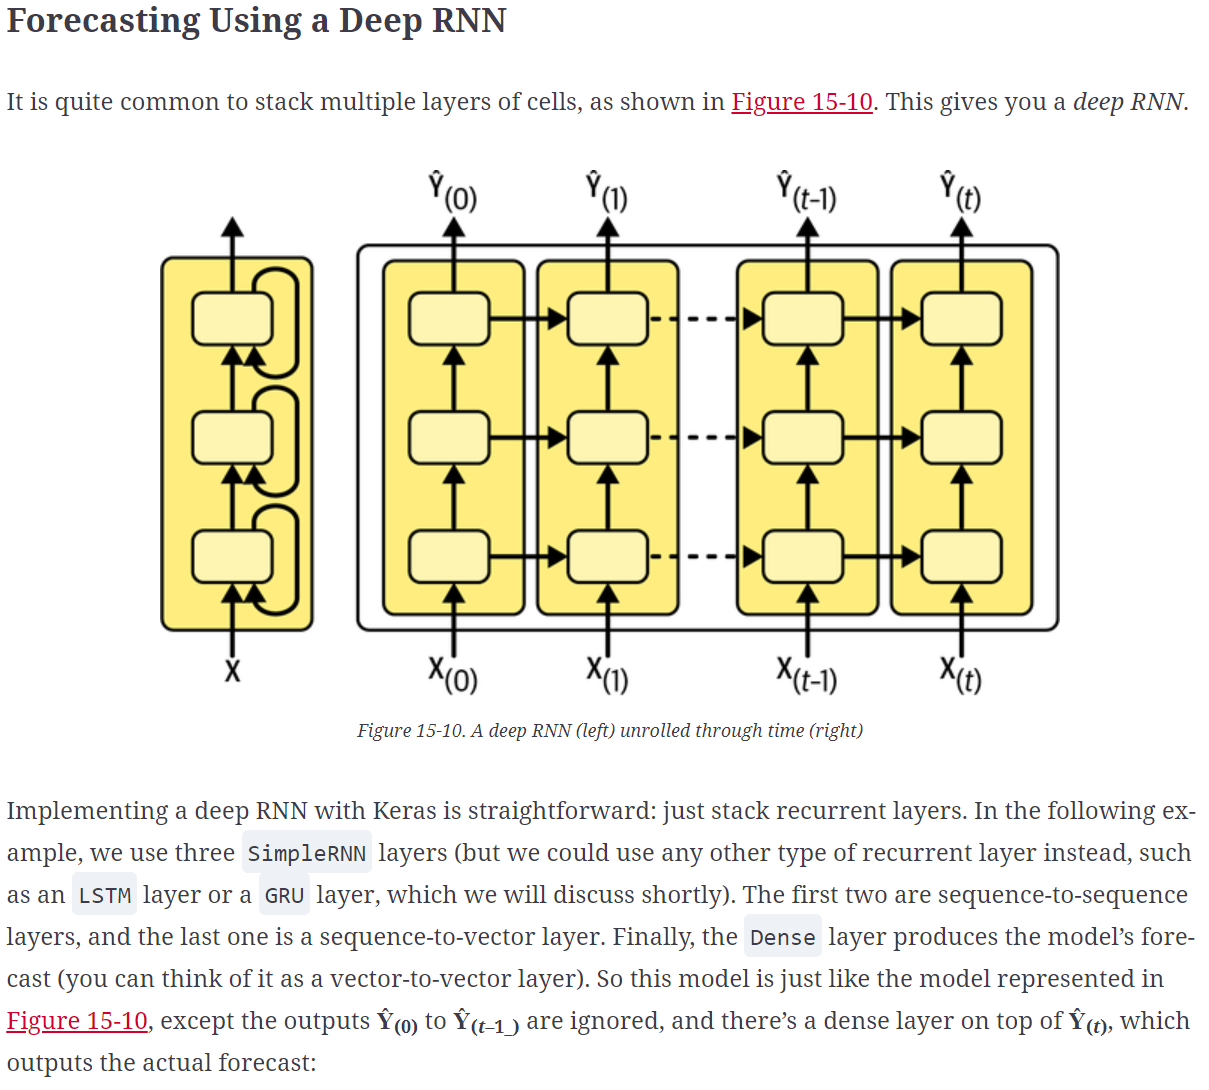

In [39]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

Make sure to set return_sequences=True for all recurrent layers (except the last one, if you only care about the last output). If you forget to set this parameter for one recurrent layer, it will output a 2D array containing only the output of the last time step, instead of a 3D array containing outputs for all time steps. The next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.

In [40]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 16s 415ms/step - loss: 0.0326 - mae: 0.1888 - val_loss: 0.0106 - val_mae: 0.0980
Epoch 2/500
33/33 [==============================] - 15s 442ms/step - loss: 0.0088 - mae: 0.1045 - val_loss: 0.0071 - val_mae: 0.1027
Epoch 3/500
33/33 [==============================] - 14s 424ms/step - loss: 0.0062 - mae: 0.0813 - val_loss: 0.0025 - val_mae: 0.0485
Epoch 4/500
33/33 [==============================] - 14s 406ms/step - loss: 0.0050 - mae: 0.0691 - val_loss: 0.0024 - val_mae: 0.0484
Epoch 5/500
33/33 [==============================] - 13s 401ms/step - loss: 0.0045 - mae: 0.0630 - val_loss: 0.0031 - val_mae: 0.0582
Epoch 6/500
33/33 [==============================] - 15s 457ms/step - loss: 0.0042 - mae: 0.0616 - val_loss: 0.0021 - val_mae: 0.0409
Epoch 7/500
33/33 [==============================] - 14s 423ms/step - loss: 0.0037 - mae: 0.0555 - val_loss: 0.0019 - val_mae: 0.0376
Epoch 8/500
33/33 [==============================] - 13s 403ms

Epoch 62/500
33/33 [==============================] - 13s 383ms/step - loss: 0.0025 - mae: 0.0421 - val_loss: 0.0017 - val_mae: 0.0329
Epoch 63/500
33/33 [==============================] - 13s 402ms/step - loss: 0.0025 - mae: 0.0418 - val_loss: 0.0023 - val_mae: 0.0424
Epoch 64/500
33/33 [==============================] - 13s 390ms/step - loss: 0.0025 - mae: 0.0414 - val_loss: 0.0021 - val_mae: 0.0398
Epoch 65/500
33/33 [==============================] - 14s 433ms/step - loss: 0.0026 - mae: 0.0436 - val_loss: 0.0016 - val_mae: 0.0299
Epoch 66/500
33/33 [==============================] - 13s 398ms/step - loss: 0.0026 - mae: 0.0424 - val_loss: 0.0024 - val_mae: 0.0466
Epoch 67/500
33/33 [==============================] - 15s 446ms/step - loss: 0.0026 - mae: 0.0432 - val_loss: 0.0019 - val_mae: 0.0342
Epoch 68/500
33/33 [==============================] - 16s 489ms/step - loss: 0.0025 - mae: 0.0420 - val_loss: 0.0017 - val_mae: 0.0317
Epoch 69/500
33/33 [==============================] - 1

29697.31204211712

## Multivariate time series

A great quality of neural networks is their flexibility: in particular, they can deal with multivariate time series with almost no change to their architecture. For example, let’s try to forecast the rail time series using both the bus and rail data as input. In fact, let’s also throw in the day type! Since we can always know in advance whether tomorrow is going to be a weekday, a weekend, or a holiday, we can shift the day type series one day into the future, so that the model is given tomorrow’s day type as input. For simplicity, we’ll do this processing using Pandas:

Now df_mulvar is a DataFrame with five columns: the bus and rail data, plus three columns containing the one-hot encoding of the next day’s type (recall that there are three possible day types, W, A, and U). Next we can proceed much like we did earlier. First we split the data into three periods, for training, validation, and testing:

In [41]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [42]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [43]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

Notice that the only difference from the univar_model RNN we built earlier is the input shape: at each time step, the model now receives five inputs instead of one. This model actually reaches a validation MAE of 22,062.

In [44]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [45]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 5s 110ms/step - loss: 0.0149 - mae: 0.1203 - val_loss: 0.0011 - val_mae: 0.0374
Epoch 2/500
33/33 [==============================] - 3s 91ms/step - loss: 0.0020 - mae: 0.0454 - val_loss: 0.0013 - val_mae: 0.0400
Epoch 3/500
33/33 [==============================] - 3s 85ms/step - loss: 0.0018 - mae: 0.0433 - val_loss: 7.0338e-04 - val_mae: 0.0273
Epoch 4/500
33/33 [==============================] - 3s 95ms/step - loss: 0.0019 - mae: 0.0436 - val_loss: 0.0015 - val_mae: 0.0450
Epoch 5/500
33/33 [==============================] - 3s 97ms/step - loss: 0.0015 - mae: 0.0373 - val_loss: 7.7001e-04 - val_mae: 0.0286
Epoch 6/500
33/33 [==============================] - 4s 117ms/step - loss: 0.0016 - mae: 0.0396 - val_loss: 9.0507e-04 - val_mae: 0.0327
Epoch 7/500
33/33 [==============================] - 4s 105ms/step - loss: 0.0014 - mae: 0.0375 - val_loss: 6.8901e-04 - val_mae: 0.0267
Epoch 8/500
33/33 [==============================] - 3s 9

33/33 [==============================] - 3s 96ms/step - loss: 0.0011 - mae: 0.0330 - val_loss: 8.8374e-04 - val_mae: 0.0318
Epoch 62/500
33/33 [==============================] - 3s 94ms/step - loss: 0.0012 - mae: 0.0354 - val_loss: 6.9740e-04 - val_mae: 0.0255
Epoch 63/500
33/33 [==============================] - 3s 91ms/step - loss: 0.0014 - mae: 0.0376 - val_loss: 6.4345e-04 - val_mae: 0.0247
Epoch 64/500
33/33 [==============================] - 3s 86ms/step - loss: 0.0011 - mae: 0.0314 - val_loss: 0.0020 - val_mae: 0.0560
Epoch 65/500
33/33 [==============================] - 3s 86ms/step - loss: 0.0014 - mae: 0.0389 - val_loss: 9.2879e-04 - val_mae: 0.0345
Epoch 66/500
33/33 [==============================] - 3s 92ms/step - loss: 0.0011 - mae: 0.0328 - val_loss: 9.6382e-04 - val_mae: 0.0354
Epoch 67/500
33/33 [==============================] - 3s 88ms/step - loss: 0.0014 - mae: 0.0382 - val_loss: 0.0014 - val_mae: 0.0448
Epoch 68/500
33/33 [==============================] - 3s 84ms/

33/33 [==============================] - 4s 108ms/step - loss: 0.0010 - mae: 0.0309 - val_loss: 0.0012 - val_mae: 0.0409
Epoch 122/500
33/33 [==============================] - 4s 116ms/step - loss: 0.0011 - mae: 0.0338 - val_loss: 0.0023 - val_mae: 0.0601
Epoch 123/500
33/33 [==============================] - 3s 97ms/step - loss: 0.0013 - mae: 0.0389 - val_loss: 0.0011 - val_mae: 0.0375
Epoch 124/500
33/33 [==============================] - 3s 88ms/step - loss: 0.0012 - mae: 0.0359 - val_loss: 8.1540e-04 - val_mae: 0.0308
Epoch 125/500
3/3 [==============================] - 0s 19ms/step - loss: 6.1898e-04 - mae: 0.0233


23342.182859778404

In fact, it’s not too hard to make the RNN forecast both the bus and rail ridership. You just need to change the targets when creating the datasets, setting them to mulvar_train[["bus", "rail"]][seq_length:] for the training set, and mulvar_valid[["bus", "rail"]][seq_length:] for the validation set. You must also add an extra neuron in the output Dense layer, since it must now make two forecasts: one for tomorrow’s bus ridership, and the other for rail. That’s all there is to it!

In [46]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 4s 95ms/step - loss: 0.0238 - mae: 0.1545 - val_loss: 0.0047 - val_mae: 0.0771
Epoch 2/500
33/33 [==============================] - 3s 82ms/step - loss: 0.0036 - mae: 0.0591 - val_loss: 0.0016 - val_mae: 0.0420
Epoch 3/500
33/33 [==============================] - 3s 86ms/step - loss: 0.0027 - mae: 0.0503 - val_loss: 0.0011 - val_mae: 0.0320
Epoch 4/500
33/33 [==============================] - 3s 103ms/step - loss: 0.0024 - mae: 0.0484 - val_loss: 0.0015 - val_mae: 0.0419
Epoch 5/500
33/33 [==============================] - 3s 96ms/step - loss: 0.0023 - mae: 0.0468 - val_loss: 0.0010 - val_mae: 0.0327
Epoch 6/500
33/33 [==============================] - 3s 104ms/step - loss: 0.0022 - mae: 0.0459 - val_loss: 0.0014 - val_mae: 0.0420
Epoch 7/500
33/33 [==============================] - 3s 95ms/step - loss: 0.0021 - mae: 0.0461 - val_loss: 0.0014 - val_mae: 0.0407
Epoch 8/500
33/33 [==============================] - 3s 87ms/step - loss: 

33/33 [==============================] - 3s 93ms/step - loss: 0.0012 - mae: 0.0345 - val_loss: 7.7257e-04 - val_mae: 0.0295
Epoch 62/500
33/33 [==============================] - 3s 94ms/step - loss: 0.0012 - mae: 0.0339 - val_loss: 8.5972e-04 - val_mae: 0.0319
Epoch 63/500
33/33 [==============================] - 3s 93ms/step - loss: 0.0012 - mae: 0.0341 - val_loss: 8.2600e-04 - val_mae: 0.0313
Epoch 64/500
33/33 [==============================] - 3s 103ms/step - loss: 0.0012 - mae: 0.0346 - val_loss: 9.1430e-04 - val_mae: 0.0332
Epoch 65/500
33/33 [==============================] - 4s 115ms/step - loss: 0.0012 - mae: 0.0344 - val_loss: 6.9136e-04 - val_mae: 0.0278
Epoch 66/500
33/33 [==============================] - 5s 159ms/step - loss: 0.0012 - mae: 0.0339 - val_loss: 7.3210e-04 - val_mae: 0.0287
Epoch 67/500
33/33 [==============================] - 4s 130ms/step - loss: 0.0012 - mae: 0.0339 - val_loss: 6.9385e-04 - val_mae: 0.0282
Epoch 68/500
33/33 [==============================

33/33 [==============================] - 4s 119ms/step - loss: 0.0011 - mae: 0.0320 - val_loss: 8.2247e-04 - val_mae: 0.0313
Epoch 121/500
33/33 [==============================] - 4s 117ms/step - loss: 0.0011 - mae: 0.0319 - val_loss: 6.4526e-04 - val_mae: 0.0264
Epoch 122/500
33/33 [==============================] - 4s 123ms/step - loss: 0.0010 - mae: 0.0313 - val_loss: 7.8546e-04 - val_mae: 0.0305
Epoch 123/500
33/33 [==============================] - 6s 173ms/step - loss: 0.0011 - mae: 0.0324 - val_loss: 6.9242e-04 - val_mae: 0.0274
Epoch 124/500
33/33 [==============================] - 5s 132ms/step - loss: 0.0011 - mae: 0.0323 - val_loss: 6.5810e-04 - val_mae: 0.0270
Epoch 125/500
33/33 [==============================] - 4s 125ms/step - loss: 0.0011 - mae: 0.0326 - val_loss: 6.8533e-04 - val_mae: 0.0276
Epoch 126/500
33/33 [==============================] - 5s 157ms/step - loss: 0.0011 - mae: 0.0322 - val_loss: 7.0601e-04 - val_mae: 0.0284
Epoch 127/500
33/33 [====================

25745.632126927376

In [47]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [48]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 20ms/step
bus 26648
rail 24842


## Forecasting Several Steps Ahead

So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict the ridership 2 weeks from now, we could just change the targets to be the value 14 days ahead instead of 1 day ahead). But what if we want to predict the next 14 values?

The first option is to take the univar_model RNN we trained earlier for the rail time series, make it predict the next value, and add that value to the inputs, acting as if the predicted value had actually occurred; we would then use the model again to predict the following value, and so on, as in the following code:

In this code, we take the rail ridership of the first 56 days of the validation period, and we convert the data to a NumPy array of shape [1, 56, 1] (recall that recurrent layers expect 3D inputs). Then we repeatedly use the model to forecast the next value, and we append each forecast to the input series, along the time axis (axis=1). 

In [49]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 61ms/step


<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

(200000.0, 800000.0)

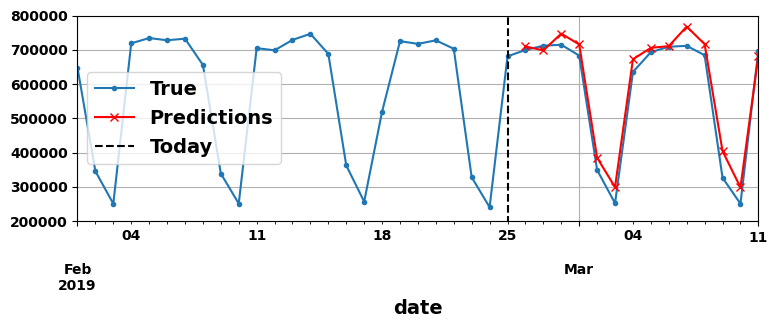

In [50]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 14 next values at once:

The second option is to train an RNN to predict the next 14 values in one shot. We can still use a sequence-to-vector model, but it will output 14 values instead of 1. However, we first need to change the targets to be vectors containing the next 14 values. To do this, we can use timeseries_dataset_from_array() again, but this time asking it to create datasets without targets (targets=None) and with longer sequences, of length seq_length + 14. Then we can use the datasets’ map() method to apply a custom function to each batch of sequences, splitting them into inputs and targets. In this example, we use the multivariate time series as input (using all five columns), and we forecast the rail ridership for the next 14 days:

In [51]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [52]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)  # output layer has 14 outputs, one for each day
])

In [53]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 6s 132ms/step - loss: 0.1231 - mae: 0.3727 - val_loss: 0.0324 - val_mae: 0.2028
Epoch 2/500
33/33 [==============================] - 4s 117ms/step - loss: 0.0219 - mae: 0.1654 - val_loss: 0.0155 - val_mae: 0.1353
Epoch 3/500
33/33 [==============================] - 6s 170ms/step - loss: 0.0148 - mae: 0.1376 - val_loss: 0.0124 - val_mae: 0.1188
Epoch 4/500
33/33 [==============================] - 4s 126ms/step - loss: 0.0125 - mae: 0.1257 - val_loss: 0.0104 - val_mae: 0.1110
Epoch 5/500
33/33 [==============================] - 4s 108ms/step - loss: 0.0112 - mae: 0.1179 - val_loss: 0.0093 - val_mae: 0.1043
Epoch 6/500
33/33 [==============================] - 3s 99ms/step - loss: 0.0102 - mae: 0.1115 - val_loss: 0.0084 - val_mae: 0.0989
Epoch 7/500
33/33 [==============================] - 4s 109ms/step - loss: 0.0095 - mae: 0.1065 - val_loss: 0.0076 - val_mae: 0.0936
Epoch 8/500
33/33 [==============================] - 3s 99ms/step - lo

33/33 [==============================] - 4s 111ms/step - loss: 0.0037 - mae: 0.0540 - val_loss: 0.0016 - val_mae: 0.0396
Epoch 63/500
33/33 [==============================] - 4s 109ms/step - loss: 0.0036 - mae: 0.0528 - val_loss: 0.0016 - val_mae: 0.0386
Epoch 64/500
33/33 [==============================] - 3s 95ms/step - loss: 0.0036 - mae: 0.0530 - val_loss: 0.0018 - val_mae: 0.0434
Epoch 65/500
33/33 [==============================] - 4s 104ms/step - loss: 0.0036 - mae: 0.0527 - val_loss: 0.0017 - val_mae: 0.0402
Epoch 66/500
33/33 [==============================] - 3s 92ms/step - loss: 0.0036 - mae: 0.0525 - val_loss: 0.0016 - val_mae: 0.0391
Epoch 67/500
33/33 [==============================] - 3s 98ms/step - loss: 0.0038 - mae: 0.0560 - val_loss: 0.0020 - val_mae: 0.0462
Epoch 68/500
33/33 [==============================] - 4s 108ms/step - loss: 0.0036 - mae: 0.0529 - val_loss: 0.0017 - val_mae: 0.0418
Epoch 69/500
33/33 [==============================] - 3s 104ms/step - loss: 0.

33/33 [==============================] - 4s 112ms/step - loss: 0.0032 - mae: 0.0479 - val_loss: 0.0014 - val_mae: 0.0356
Epoch 124/500
33/33 [==============================] - 3s 100ms/step - loss: 0.0032 - mae: 0.0486 - val_loss: 0.0017 - val_mae: 0.0399
Epoch 125/500
33/33 [==============================] - 3s 98ms/step - loss: 0.0032 - mae: 0.0478 - val_loss: 0.0015 - val_mae: 0.0360
Epoch 126/500
33/33 [==============================] - 3s 96ms/step - loss: 0.0032 - mae: 0.0480 - val_loss: 0.0014 - val_mae: 0.0353
Epoch 127/500
33/33 [==============================] - 4s 129ms/step - loss: 0.0032 - mae: 0.0476 - val_loss: 0.0014 - val_mae: 0.0353
Epoch 128/500
33/33 [==============================] - 4s 123ms/step - loss: 0.0032 - mae: 0.0475 - val_loss: 0.0014 - val_mae: 0.0350
Epoch 129/500
33/33 [==============================] - 3s 96ms/step - loss: 0.0032 - mae: 0.0478 - val_loss: 0.0015 - val_mae: 0.0366
Epoch 130/500
33/33 [==============================] - 5s 145ms/step - l

Epoch 184/500
33/33 [==============================] - 6s 167ms/step - loss: 0.0031 - mae: 0.0467 - val_loss: 0.0015 - val_mae: 0.0359
Epoch 185/500
33/33 [==============================] - 6s 191ms/step - loss: 0.0030 - mae: 0.0460 - val_loss: 0.0014 - val_mae: 0.0343
Epoch 186/500
33/33 [==============================] - 7s 205ms/step - loss: 0.0031 - mae: 0.0465 - val_loss: 0.0014 - val_mae: 0.0346
Epoch 187/500
33/33 [==============================] - 6s 165ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0014 - val_mae: 0.0346
Epoch 188/500
33/33 [==============================] - 4s 128ms/step - loss: 0.0031 - mae: 0.0468 - val_loss: 0.0014 - val_mae: 0.0356
Epoch 189/500
33/33 [==============================] - 4s 126ms/step - loss: 0.0031 - mae: 0.0469 - val_loss: 0.0014 - val_mae: 0.0347
Epoch 190/500
33/33 [==============================] - 4s 116ms/step - loss: 0.0031 - mae: 0.0462 - val_loss: 0.0014 - val_mae: 0.0354
Epoch 191/500
33/33 [==============================] - 

Epoch 245/500
33/33 [==============================] - 4s 131ms/step - loss: 0.0030 - mae: 0.0453 - val_loss: 0.0016 - val_mae: 0.0380
Epoch 246/500
33/33 [==============================] - 6s 174ms/step - loss: 0.0030 - mae: 0.0461 - val_loss: 0.0014 - val_mae: 0.0347
Epoch 247/500
33/33 [==============================] - 6s 167ms/step - loss: 0.0030 - mae: 0.0461 - val_loss: 0.0014 - val_mae: 0.0352
Epoch 248/500
33/33 [==============================] - 5s 136ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0014 - val_mae: 0.0349
Epoch 249/500
33/33 [==============================] - 5s 145ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0014 - val_mae: 0.0342
Epoch 250/500
33/33 [==============================] - 5s 154ms/step - loss: 0.0030 - mae: 0.0458 - val_loss: 0.0013 - val_mae: 0.0339
Epoch 251/500
33/33 [==============================] - 4s 106ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0014 - val_mae: 0.0347
Epoch 252/500
33/33 [==============================] - 

Epoch 306/500
33/33 [==============================] - 5s 139ms/step - loss: 0.0029 - mae: 0.0446 - val_loss: 0.0015 - val_mae: 0.0366
Epoch 307/500
33/33 [==============================] - 4s 130ms/step - loss: 0.0029 - mae: 0.0449 - val_loss: 0.0014 - val_mae: 0.0353
Epoch 308/500
33/33 [==============================] - 5s 157ms/step - loss: 0.0029 - mae: 0.0448 - val_loss: 0.0015 - val_mae: 0.0369
Epoch 309/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0335


33547.65847325325

In [54]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 283ms/step


Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

Forecasting Using a Sequence-to-Sequence Model
Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just for the output at the last time step.

This means there will be many more error gradients flowing through the model, and they won’t have to flow through time as much since they will come from the output of each time step, not just the last one. This will both stabilize and speed up training.

To be clear, at time step 0 the model will output a vector containing the forecasts for time steps 1 to 14, then at time step 1 the model will forecast time steps 2 to 15, and so on. In other words, the targets are sequences of consecutive windows, shifted by one time step at each time step. The target is not a vector anymore, but a sequence of the same length as the inputs, containing a 14-dimensional vector at each step.

Preparing the datasets is not trivial, since each instance has a window as input and a sequence of windows as output. One way to do this is to use the to_windows() utility function we created earlier, twice in a row, to get windows of consecutive windows. For example, let’s turn the series of numbers 0 to 6 into a dataset containing sequences of 4 consecutive windows, each of length 3:

To prepare the datasets, we can use `to_windows()` twice, to get sequences of consecutive windows, like this:

In [55]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

Then we can split these elements into the desired inputs and targets:

In [56]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [57]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [58]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

It is almost identical to our previous model: the only difference is that we set return_sequences=True in the SimpleRNN layer. This way, it will output a sequence of vectors (each of size 32), instead of outputting a single vector at the last time step. The Dense layer is smart enough to handle sequences as input: it will be applied at each time step, taking a 32-dimensional vector as input and outputting a 14-dimensional vector. In fact, another way to get the exact same result is to use a Conv1D layer with a kernel size of 1: Conv1D(14, kernel_size=1).

In [59]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [60]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 8s 205ms/step - loss: 0.0599 - mae: 0.2515 - val_loss: 0.0164 - val_mae: 0.1451
Epoch 2/500
33/33 [==============================] - 6s 192ms/step - loss: 0.0104 - mae: 0.1111 - val_loss: 0.0086 - val_mae: 0.0929
Epoch 3/500
33/33 [==============================] - 11s 327ms/step - loss: 0.0071 - mae: 0.0853 - val_loss: 0.0071 - val_mae: 0.0830
Epoch 4/500
33/33 [==============================] - 8s 237ms/step - loss: 0.0060 - mae: 0.0761 - val_loss: 0.0062 - val_mae: 0.0770
Epoch 5/500
33/33 [==============================] - 6s 187ms/step - loss: 0.0055 - mae: 0.0711 - val_loss: 0.0054 - val_mae: 0.0691
Epoch 6/500
33/33 [==============================] - 8s 235ms/step - loss: 0.0052 - mae: 0.0689 - val_loss: 0.0058 - val_mae: 0.0736
Epoch 7/500
33/33 [==============================] - 7s 210ms/step - loss: 0.0050 - mae: 0.0667 - val_loss: 0.0052 - val_mae: 0.0684
Epoch 8/500
33/33 [==============================] - 5s 145ms/step -

33/33 [==============================] - 5s 160ms/step - loss: 0.0035 - mae: 0.0514 - val_loss: 0.0037 - val_mae: 0.0499
Epoch 63/500
33/33 [==============================] - 6s 182ms/step - loss: 0.0035 - mae: 0.0519 - val_loss: 0.0037 - val_mae: 0.0500
Epoch 64/500
33/33 [==============================] - 6s 185ms/step - loss: 0.0035 - mae: 0.0509 - val_loss: 0.0038 - val_mae: 0.0518
Epoch 65/500
33/33 [==============================] - 4s 122ms/step - loss: 0.0035 - mae: 0.0518 - val_loss: 0.0040 - val_mae: 0.0552
Epoch 66/500
33/33 [==============================] - 5s 150ms/step - loss: 0.0035 - mae: 0.0523 - val_loss: 0.0037 - val_mae: 0.0496
Epoch 67/500
33/33 [==============================] - 4s 121ms/step - loss: 0.0036 - mae: 0.0527 - val_loss: 0.0038 - val_mae: 0.0506
Epoch 68/500
33/33 [==============================] - 4s 128ms/step - loss: 0.0035 - mae: 0.0519 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 69/500
33/33 [==============================] - 5s 138ms/step - loss:

33/33 [==============================] - 15s 436ms/step - loss: 0.0032 - mae: 0.0488 - val_loss: 0.0037 - val_mae: 0.0483
Epoch 124/500
33/33 [==============================] - 9s 274ms/step - loss: 0.0033 - mae: 0.0490 - val_loss: 0.0036 - val_mae: 0.0481
Epoch 125/500
33/33 [==============================] - 8s 223ms/step - loss: 0.0033 - mae: 0.0488 - val_loss: 0.0037 - val_mae: 0.0499
Epoch 126/500
33/33 [==============================] - 9s 257ms/step - loss: 0.0033 - mae: 0.0490 - val_loss: 0.0036 - val_mae: 0.0479
Epoch 127/500
33/33 [==============================] - 7s 200ms/step - loss: 0.0032 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0481
Epoch 128/500
33/33 [==============================] - 7s 209ms/step - loss: 0.0032 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0480
Epoch 129/500
33/33 [==============================] - 10s 315ms/step - loss: 0.0033 - mae: 0.0491 - val_loss: 0.0036 - val_mae: 0.0480
Epoch 130/500
33/33 [==============================] - 9s 276ms/ste

Epoch 184/500
33/33 [==============================] - 7s 217ms/step - loss: 0.0032 - mae: 0.0481 - val_loss: 0.0036 - val_mae: 0.0477
Epoch 185/500
33/33 [==============================] - 7s 214ms/step - loss: 0.0032 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0475
Epoch 186/500
33/33 [==============================] - 7s 216ms/step - loss: 0.0031 - mae: 0.0475 - val_loss: 0.0036 - val_mae: 0.0478
Epoch 187/500
33/33 [==============================] - 7s 213ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0478
Epoch 188/500
33/33 [==============================] - 7s 207ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0477
Epoch 189/500
33/33 [==============================] - 6s 190ms/step - loss: 0.0031 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0476
Epoch 190/500
33/33 [==============================] - 6s 187ms/step - loss: 0.0031 - mae: 0.0472 - val_loss: 0.0036 - val_mae: 0.0479
Epoch 191/500
33/33 [==============================] - 

47234.47933793068

The training code is the same as usual. During training, all the model’s outputs are used, but after training only the output of the very last time step matters, and the rest can be ignored. For example, we can forecast the rail ridership for the next 14 days like this:

In [61]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 [==============================] - 0s 327ms/step


In [62]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 50ms/step
MAE for +1: 27,137
MAE for +2: 28,527
MAE for +3: 29,461
MAE for +4: 32,121
MAE for +5: 33,898
MAE for +6: 33,797
MAE for +7: 33,717
MAE for +8: 35,110
MAE for +9: 34,928
MAE for +10: 31,705
MAE for +11: 36,048
MAE for +12: 37,128
MAE for +13: 36,454
MAE for +14: 34,614


# Deep RNNs with Layer Norm

Handling Long Sequences
To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the unstable gradients problem, discussed in Chapter 11: it may take forever to train, or training may be unstable. Moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence. Let’s look at both these problems, starting with the unstable gradients problem.

Fighting the Unstable Gradients Problem
Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on. However, nonsaturating activation functions (e.g., ReLU) may not help as much here. In fact, they may actually lead the RNN to be even more unstable during training. Why? Well, suppose gradient descent updates the weights in a way that increases the outputs slightly at the first time step. Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those at the third, and so on until the outputs explode—and a nonsaturating activation function does not prevent that.

You can reduce this risk by using a smaller learning rate, or you can use a saturating activation function like the hyperbolic tangent (this explains why it’s the default).

In much the same way, the gradients themselves can explode. If you notice that training is unstable, you may want to monitor the size of the gradients (e.g., using TensorBoard) and perhaps use gradient clipping.

Moreover, batch normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers.

To be more precise, it is technically possible to add a BN layer to a memory cell (as you will see shortly) so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step). However, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state. In practice, this does not yield good results, as was demonstrated by César Laurent et al. in a 2015 paper:⁠7 the authors found that BN was slightly beneficial only when it was applied to the layer’s inputs, not to the hidden states. In other words, it was slightly better than nothing when applied between recurrent layers (i.e., vertically in Figure 15-10), but not within recurrent layers (i.e., horizontally). In Keras, you can apply BN between layers simply by adding a BatchNormalization layer before each recurrent layer, but it will slow down training, and it may not help much.

Another form of normalization often works better with RNNs: layer normalization. This idea was introduced by Jimmy Lei Ba et al. in a 2016 paper:⁠8 it is very similar to batch normalization, but instead of normalizing across the batch dimension, layer normalization normalizes across the features dimension. One advantage is that it can compute the required statistics on the fly, at each time step, independently for each instance. This also means that it behaves the same way during training and testing (as opposed to BN), and it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set, like BN does. Like BN, layer normalization learns a scale and an offset parameter for each input. In an RNN, it is typically used right after the linear combination of the inputs and the hidden states.

Let’s use Keras to implement layer normalization within a simple memory cell. To do this, we need to define a custom memory cell, which is just like a regular layer, except its call() method takes two arguments: the inputs at the current time step and the hidden states from the previous time step.

Note that the states argument is a list containing one or more tensors. In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an LSTMCell has a long-term state and a short-term state, as you will see shortly). A cell must also have a state_size attribute and an output_size attribute. In a simple RNN, both are simply equal to the number of units. The following code implements a custom memory cell that will behave like a SimpleRNNCell, except it will also apply layer normalization at each time step:

In [63]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

Our LNSimpleRNNCell class inherits from the tf.keras.layers.Layer class, just like any custom layer.

The constructor takes the number of units and the desired activation function and sets the state_size and output_size attributes, then creates a SimpleRNNCell with no activation function (because we want to perform layer normalization after the linear operation but before the activation function).⁠9 Then the constructor creates the LayerNormalization layer, and finally it fetches the desired activation function.

The call() method starts by applying the simpleRNNCell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a SimpleRNNCell, the outputs are just equal to the hidden states: in other words, new_states[0] is equal to outputs, so we can safely ignore new_states in the rest of the call() method). Next, the call() method applies layer normalization, followed by the activation function. Finally, it returns the outputs twice: once as the outputs, and once as the new hidden states. To use this custom cell, all we need to do is create a tf.keras.layers.RNN layer, passing it a cell instance:

In [64]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [65]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 19s 452ms/step - loss: 0.0601 - mae: 0.2462 - val_loss: 0.0181 - val_mae: 0.1420
Epoch 2/5
33/33 [==============================] - 15s 454ms/step - loss: 0.0149 - mae: 0.1423 - val_loss: 0.0160 - val_mae: 0.1238
Epoch 3/5
33/33 [==============================] - 14s 417ms/step - loss: 0.0126 - mae: 0.1304 - val_loss: 0.0135 - val_mae: 0.1188
Epoch 4/5
33/33 [==============================] - 14s 427ms/step - loss: 0.0114 - mae: 0.1221 - val_loss: 0.0131 - val_mae: 0.1126
Epoch 5/5
3/3 [==============================] - 0s 80ms/step - loss: 0.0119 - mae: 0.1091


109064.42999839783

# Extra Material – Creating a Custom RNN Class

The RNN class is not magical. In fact, it's not too hard to implement your own RNN class:

In [66]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Note that `@tf.function` requires the `outputs` variable to be created before the `for` loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, `@tf.function` requires the `sequences` variable to be created before the `if` statement where it is used, even if `self.return_sequences` is `False`, so we create a `TensorArray` of size 0 in this case.

In [67]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [68]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 15s 390ms/step - loss: 0.0489 - mae: 0.2285 - val_loss: 0.0179 - val_mae: 0.1434
Epoch 2/5
33/33 [==============================] - 13s 383ms/step - loss: 0.0146 - mae: 0.1435 - val_loss: 0.0153 - val_mae: 0.1291
Epoch 3/5
33/33 [==============================] - 17s 507ms/step - loss: 0.0126 - mae: 0.1332 - val_loss: 0.0142 - val_mae: 0.1192
Epoch 4/5
33/33 [==============================] - 17s 507ms/step - loss: 0.0113 - mae: 0.1224 - val_loss: 0.0121 - val_mae: 0.1122
Epoch 5/5
3/3 [==============================] - 0s 71ms/step - loss: 0.0112 - mae: 0.1046


104635.12688875198

# LSTMs

The long short-term memory (LSTM) cell was proposed in 1997⁠11 by Sepp Hochreiter and Jürgen Schmidhuber and gradually improved over the years by several researchers, such as Alex Graves, Haşim Sak,⁠12 and Wojciech Zaremba.⁠13 If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect longer-term patterns in the data. In Keras, you can simply use the LSTM layer instead of the SimpleRNN layer:

Alternatively, you could use the general-purpose tf.keras.layers.RNN layer, giving it an LSTMCell as an argument. However, the LSTM layer uses an optimized implementation when running on a GPU (see Chapter 19), so in general it is preferable to use it (the RNN layer is mostly useful when you define custom cells, as we did earlier).

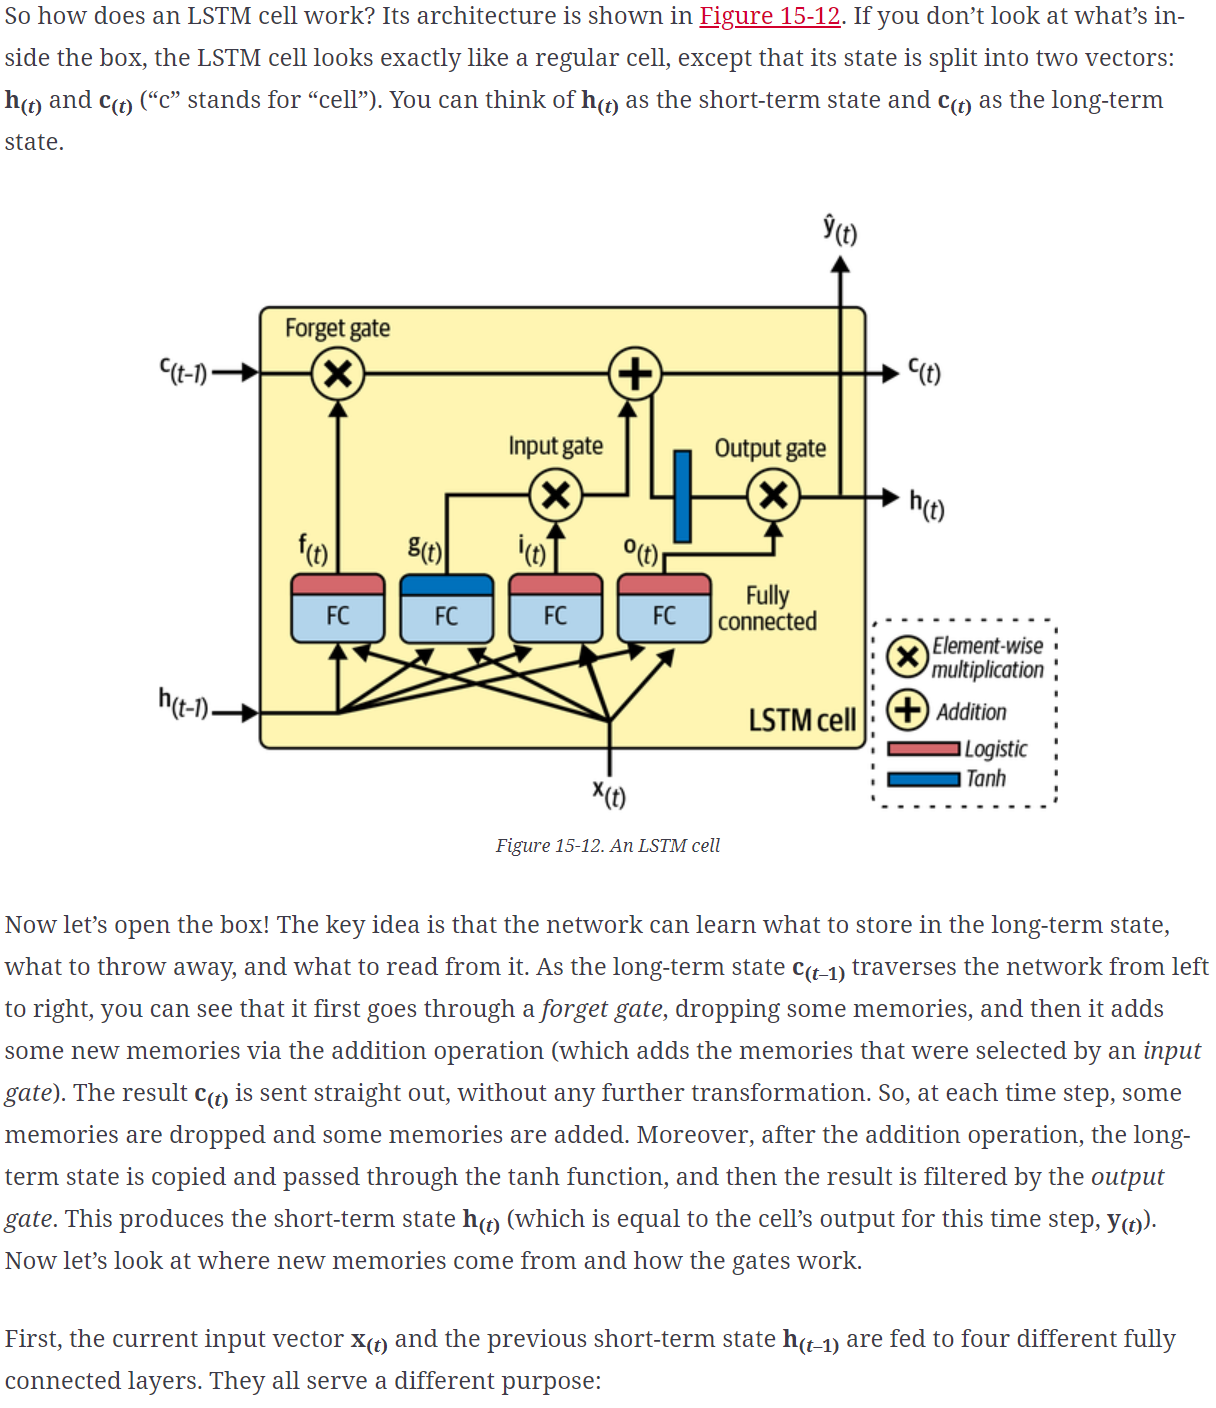
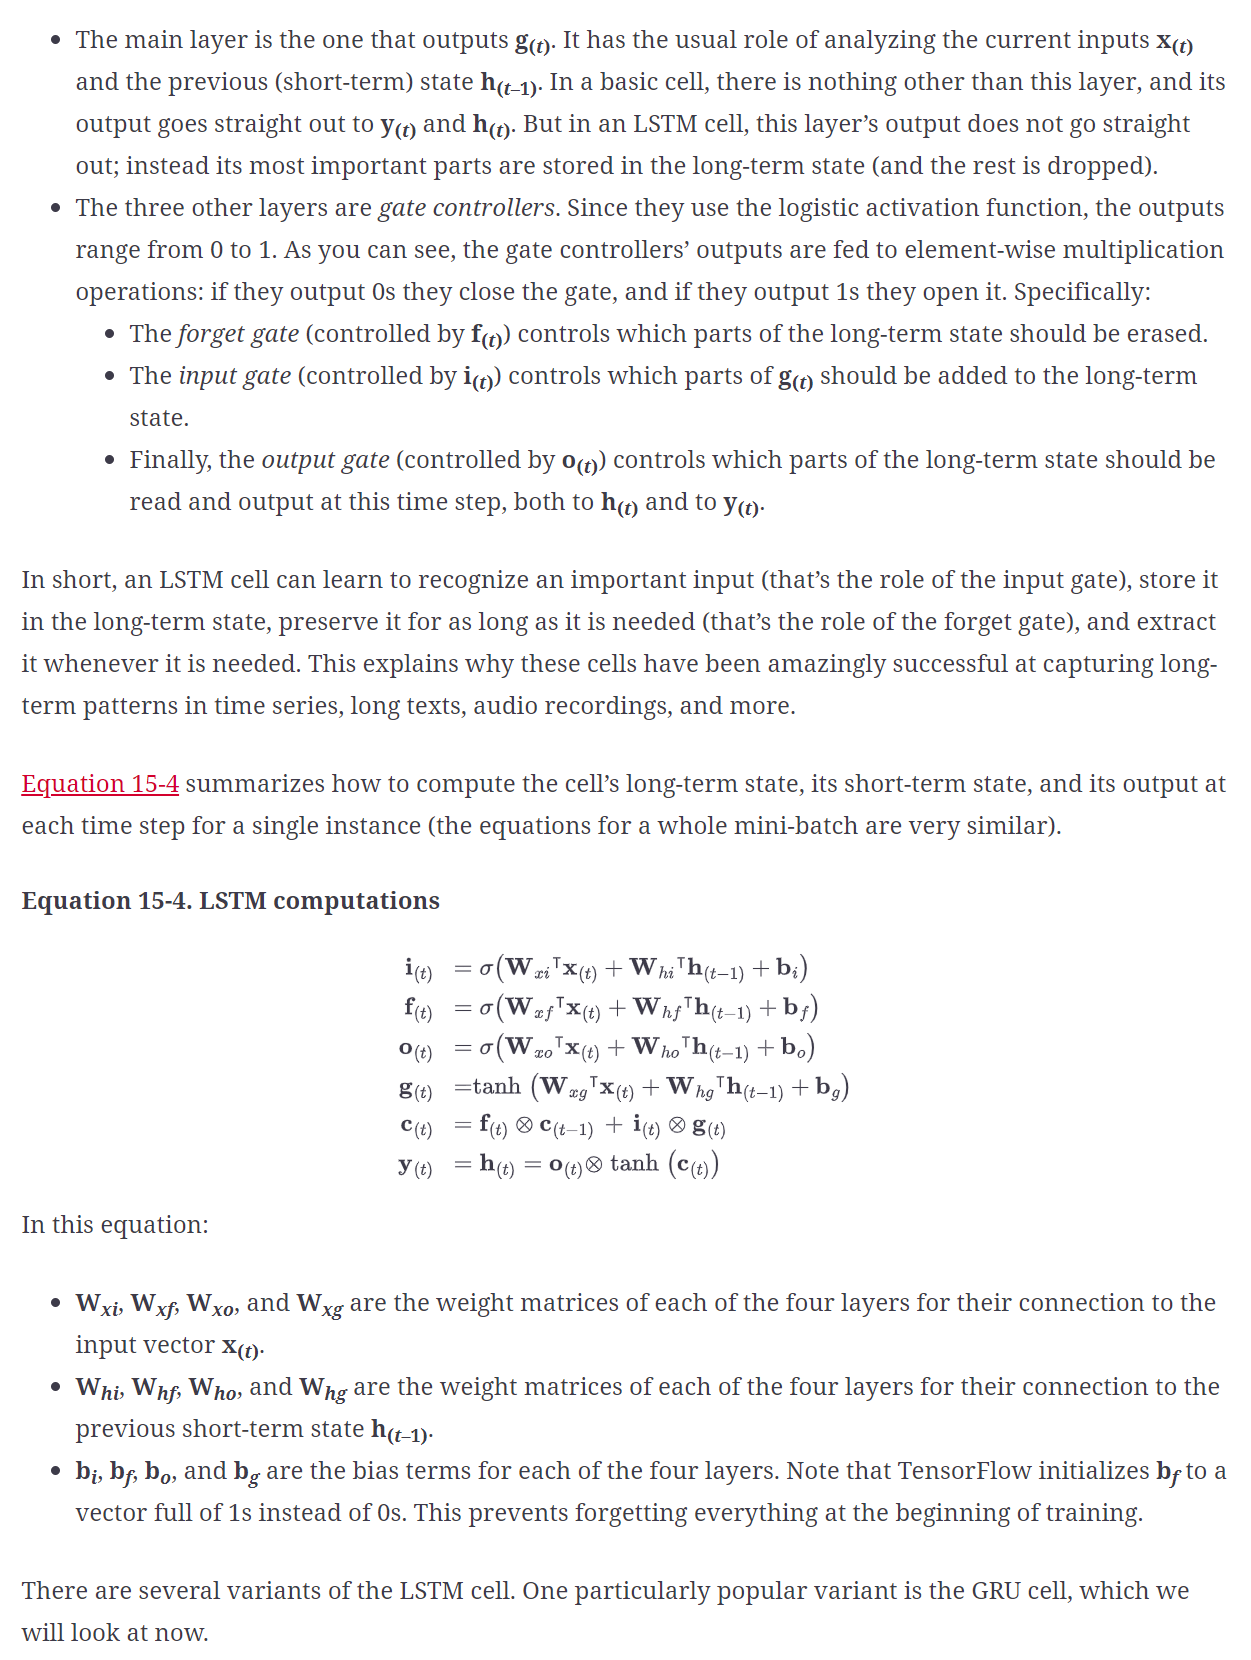

In [69]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [70]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 6s 57ms/step - loss: 0.0513 - mae: 0.2480 - val_loss: 0.0195 - val_mae: 0.1615
Epoch 2/5
33/33 [==============================] - 1s 27ms/step - loss: 0.0174 - mae: 0.1563 - val_loss: 0.0174 - val_mae: 0.1438
Epoch 3/5
33/33 [==============================] - 1s 28ms/step - loss: 0.0155 - mae: 0.1495 - val_loss: 0.0163 - val_mae: 0.1391
Epoch 4/5
33/33 [==============================] - 1s 29ms/step - loss: 0.0147 - mae: 0.1446 - val_loss: 0.0157 - val_mae: 0.1341
Epoch 5/5
3/3 [==============================] - 0s 40ms/step - loss: 0.0149 - mae: 0.1312


131159.76750850677

# GRUs

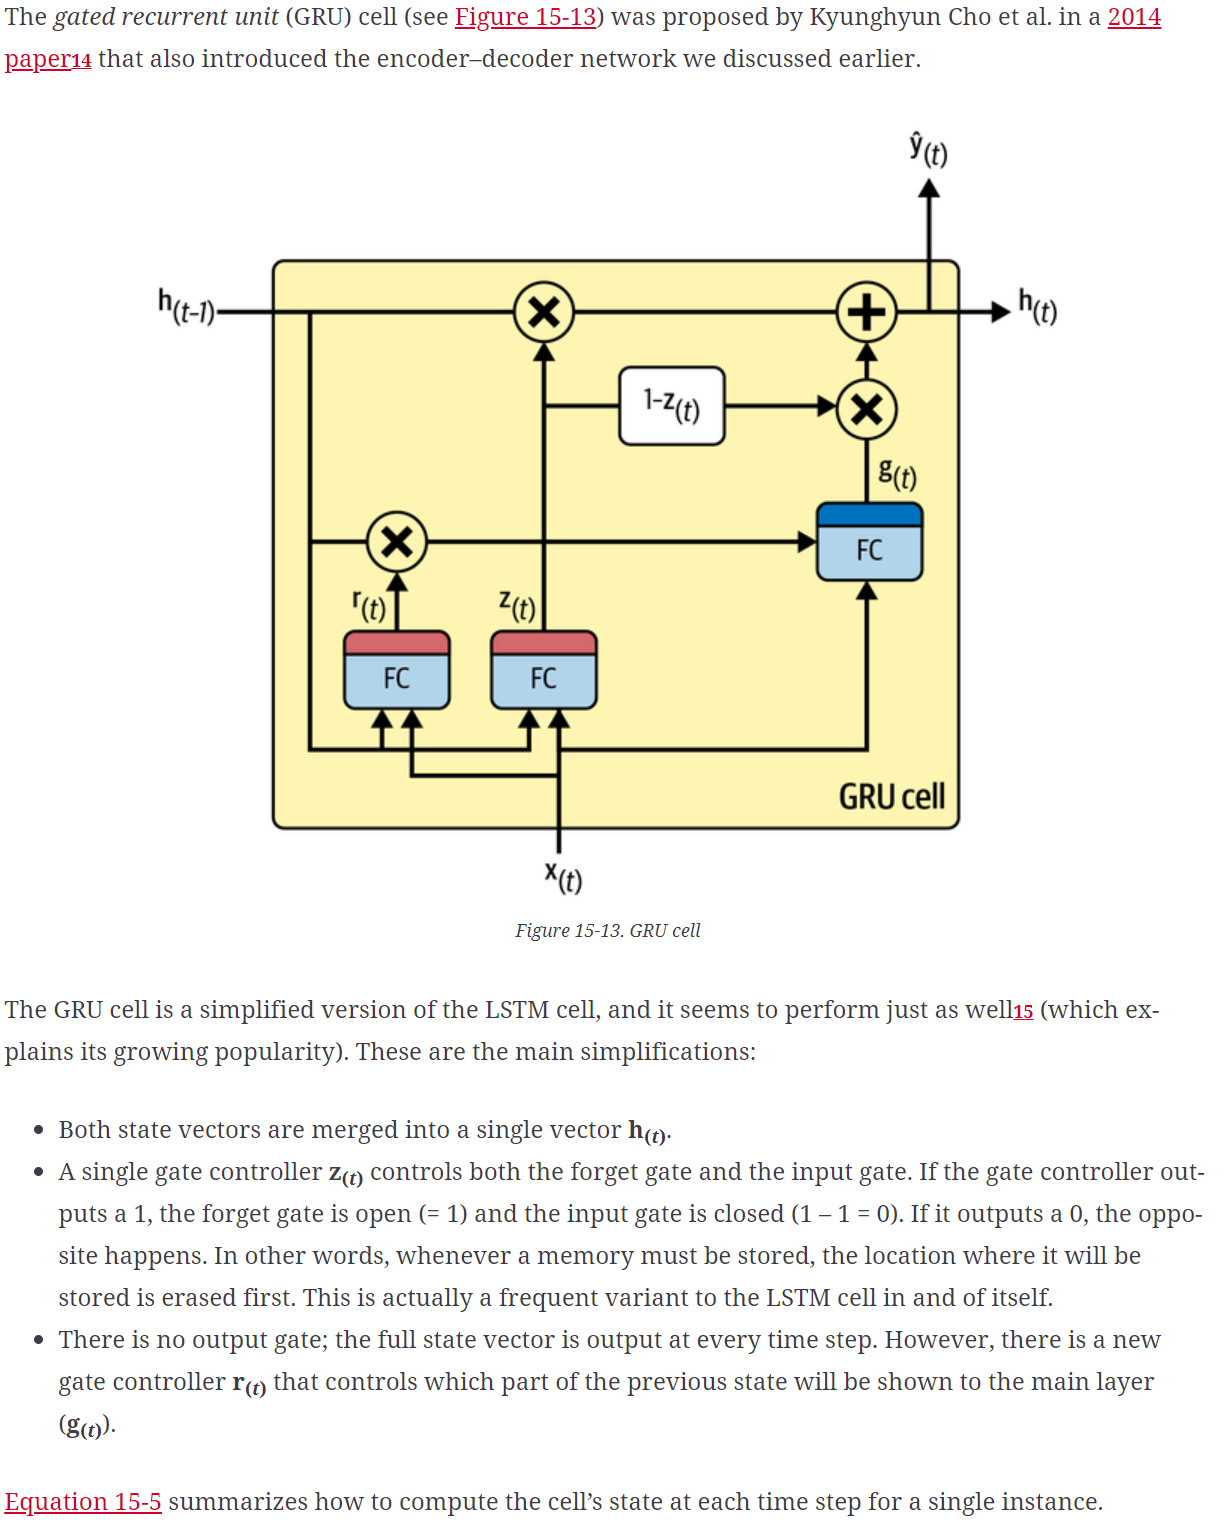
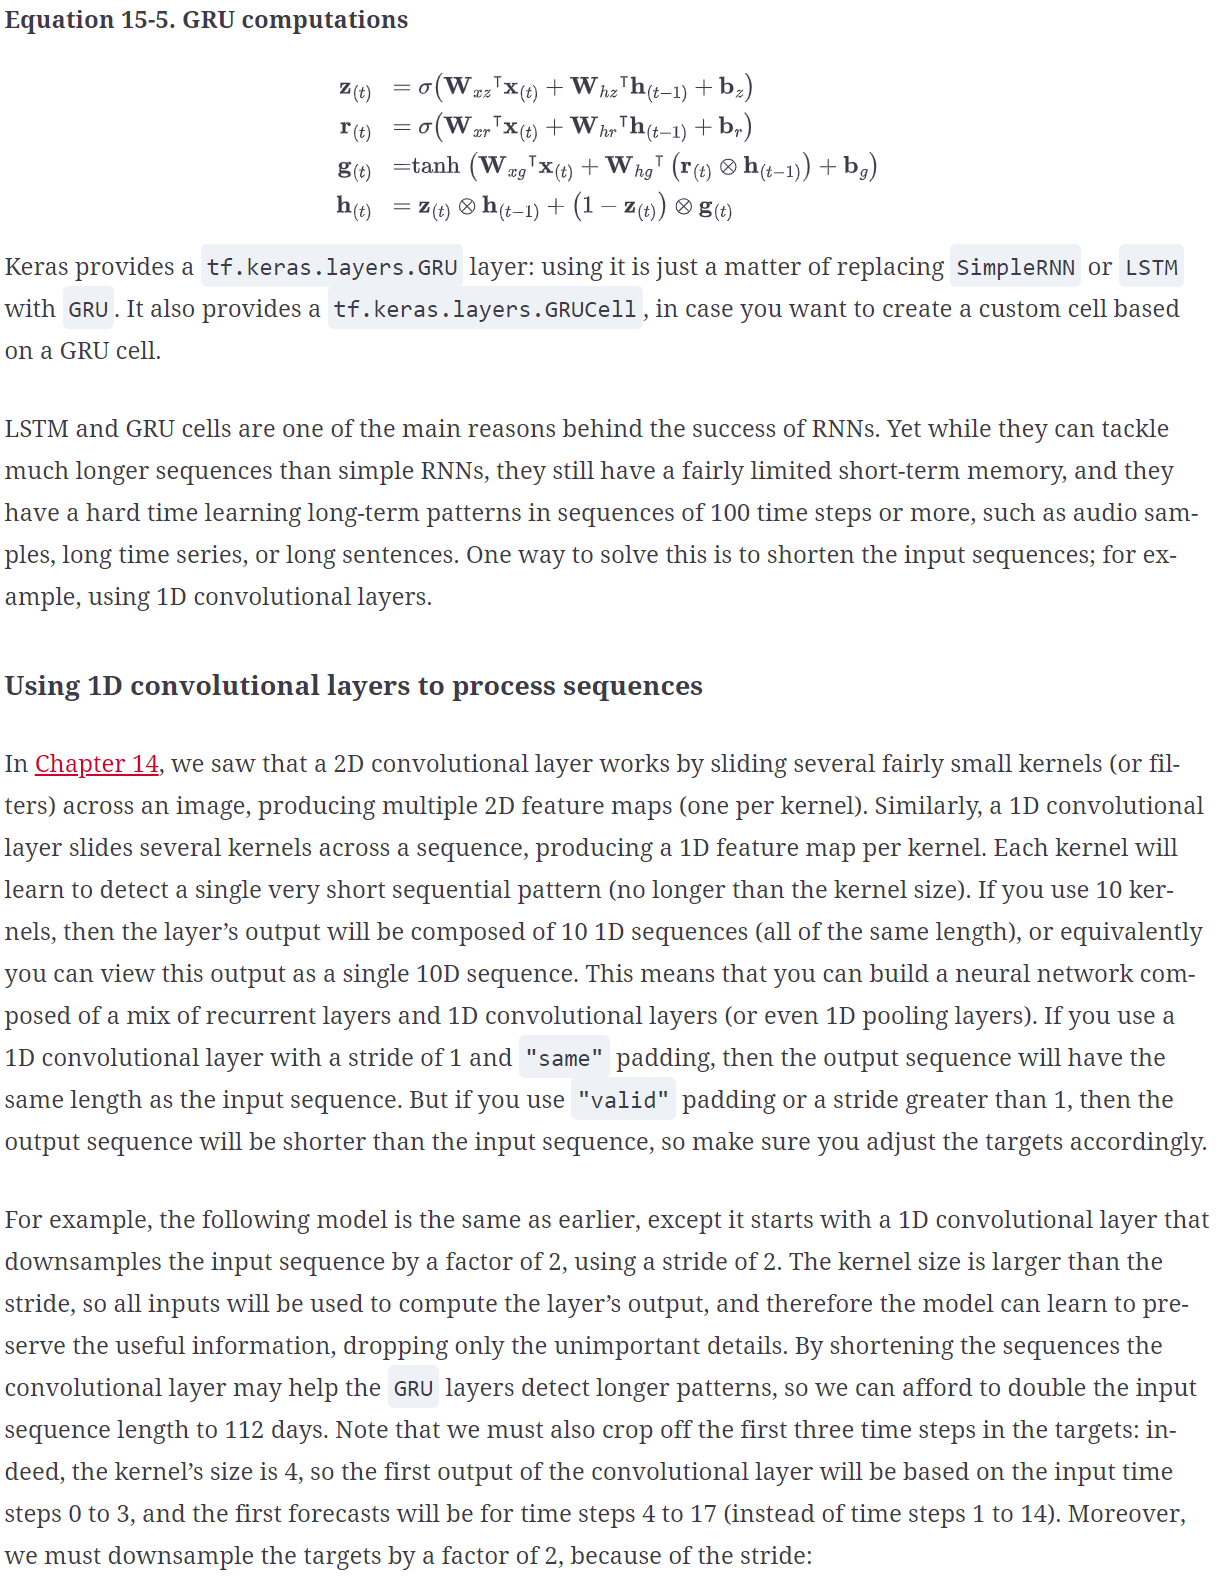

In [71]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [72]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 5s 65ms/step - loss: 0.0607 - mae: 0.2681 - val_loss: 0.0186 - val_mae: 0.1615
Epoch 2/5
33/33 [==============================] - 2s 41ms/step - loss: 0.0153 - mae: 0.1415 - val_loss: 0.0150 - val_mae: 0.1308
Epoch 3/5
33/33 [==============================] - 1s 30ms/step - loss: 0.0126 - mae: 0.1299 - val_loss: 0.0133 - val_mae: 0.1242
Epoch 4/5
33/33 [==============================] - 1s 27ms/step - loss: 0.0116 - mae: 0.1243 - val_loss: 0.0123 - val_mae: 0.1196
Epoch 5/5
3/3 [==============================] - 0s 46ms/step - loss: 0.0118 - mae: 0.1157


115676.52225494385

## Using One-Dimensional Convolutional Layers to Process Sequences

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [73]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

Just training for 5 epochs to show that it works (you can increase this if you want):

In [74]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 9s 85ms/step - loss: 0.0553 - mae: 0.2532 - val_loss: 0.0200 - val_mae: 0.1585
Epoch 2/5
31/31 [==============================] - 1s 27ms/step - loss: 0.0157 - mae: 0.1492 - val_loss: 0.0163 - val_mae: 0.1342
Epoch 3/5
31/31 [==============================] - 2s 43ms/step - loss: 0.0133 - mae: 0.1372 - val_loss: 0.0144 - val_mae: 0.1254
Epoch 4/5
31/31 [==============================] - 1s 32ms/step - loss: 0.0117 - mae: 0.1253 - val_loss: 0.0126 - val_mae: 0.1161
Epoch 5/5
1/1 [==============================] - 0s 247ms/step - loss: 0.0111 - mae: 0.1089


108863.53999376297

## WaveNet

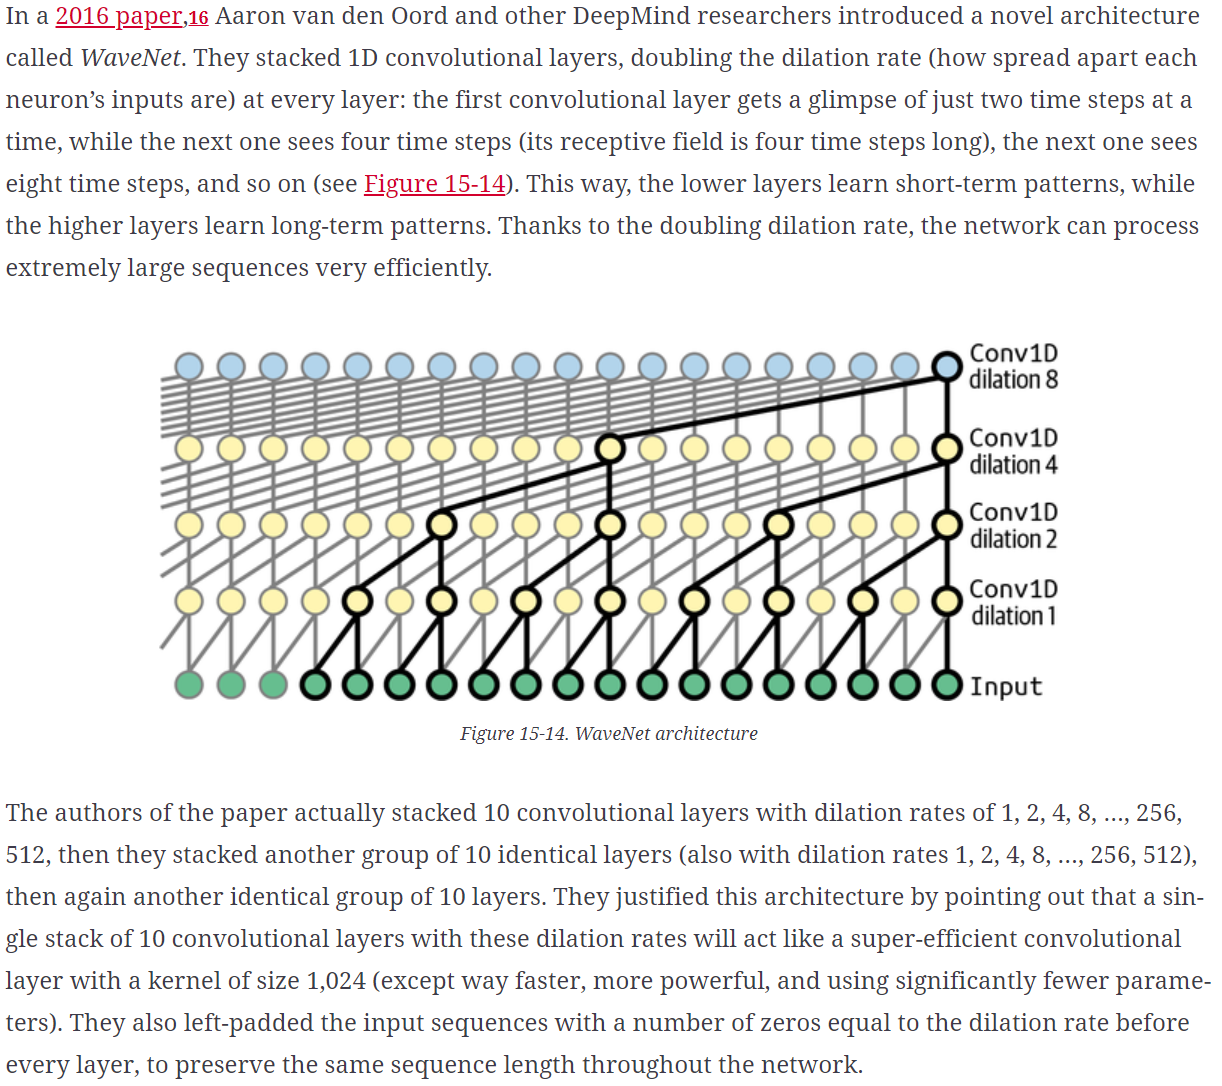

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [75]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

Just training for 5 epochs to show that it works (you can increase this if you want):

In [76]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 6s 73ms/step - loss: 0.0684 - mae: 0.2943 - val_loss: 0.0206 - val_mae: 0.1607
Epoch 2/5
31/31 [==============================] - 1s 25ms/step - loss: 0.0165 - mae: 0.1558 - val_loss: 0.0183 - val_mae: 0.1545
Epoch 3/5
31/31 [==============================] - 1s 32ms/step - loss: 0.0158 - mae: 0.1550 - val_loss: 0.0179 - val_mae: 0.1521
Epoch 4/5
31/31 [==============================] - 1s 29ms/step - loss: 0.0154 - mae: 0.1531 - val_loss: 0.0174 - val_mae: 0.1485
Epoch 5/5
1/1 [==============================] - 0s 215ms/step - loss: 0.0164 - mae: 0.1417


141674.59309101105

# Extra Material – Wavenet Implementation

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [77]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [78]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [79]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [80]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 6s 70ms/step - loss: 0.0620 - mae: 0.2707 - val_loss: 0.0202 - val_mae: 0.1444
Epoch 2/5
31/31 [==============================] - 1s 34ms/step - loss: 0.0123 - mae: 0.1272 - val_loss: 0.0129 - val_mae: 0.1202
Epoch 3/5
31/31 [==============================] - 1s 31ms/step - loss: 0.0100 - mae: 0.1117 - val_loss: 0.0116 - val_mae: 0.1134
Epoch 4/5
31/31 [==============================] - 1s 33ms/step - loss: 0.0087 - mae: 0.1032 - val_loss: 0.0101 - val_mae: 0.1059
Epoch 5/5
1/1 [==============================] - 0s 187ms/step - loss: 0.0088 - mae: 0.0963


96301.87600851059

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

## 1. to 8.

1. Here are a few RNN applications:
    * For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder–Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song
    * For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of _collaborative filtering_ for a recommender system)
    * For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car's camera)
2. An RNN layer must have three-dimensional inputs: the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32].
3. To build a deep sequence-to-sequence RNN using Keras, you must set `return_sequences=True` for all RNN layers. To build a sequence-to-vector RNN, you must set `return_sequences=True` for all RNN layers except for the top RNN layer, which must have `return_sequences=False` (or do not set this argument at all, since `False` is the default).
4. If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with `return_sequences=True` except for the top RNN layer), using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set `return_sequences=True` for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step _t_, the target should be a vector containing the values at time steps _t_ + 1 to _t_ + 7).
5. The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as the hyperbolic tangent (which is the default), and possibly use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use `LSTM` or `GRU` layers (this also helps with the unstable gradients problem).
6. An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell. See Figure 15–12.
7. An RNN layer is fundamentally sequential: in order to compute the outputs at time step _t_, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use only convolutional layers, for example by building a WaveNet architecture.
8. To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [81]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065301781/1065301781 [==============================] - 248s 0us/step


In [82]:
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [83]:
train_files

['datasets\\training.tfrecord-00000-of-00010',
 'datasets\\training.tfrecord-00001-of-00010',
 'datasets\\training.tfrecord-00002-of-00010',
 'datasets\\training.tfrecord-00003-of-00010',
 'datasets\\training.tfrecord-00004-of-00010',
 'datasets\\training.tfrecord-00005-of-00010',
 'datasets\\training.tfrecord-00006-of-00010',
 'datasets\\training.tfrecord-00007-of-00010',
 'datasets\\training.tfrecord-00008-of-00010',
 'datasets\\training.tfrecord-00009-of-00010']

In [84]:
eval_files

['datasets\\eval.tfrecord-00000-of-00010',
 'datasets\\eval.tfrecord-00001-of-00010',
 'datasets\\eval.tfrecord-00002-of-00010',
 'datasets\\eval.tfrecord-00003-of-00010',
 'datasets\\eval.tfrecord-00004-of-00010',
 'datasets\\eval.tfrecord-00005-of-00010',
 'datasets\\eval.tfrecord-00006-of-00010',
 'datasets\\eval.tfrecord-00007-of-00010',
 'datasets\\eval.tfrecord-00008-of-00010',
 'datasets\\eval.tfrecord-00009-of-00010']

In [85]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [86]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [87]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [88]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [89]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [90]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [91]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

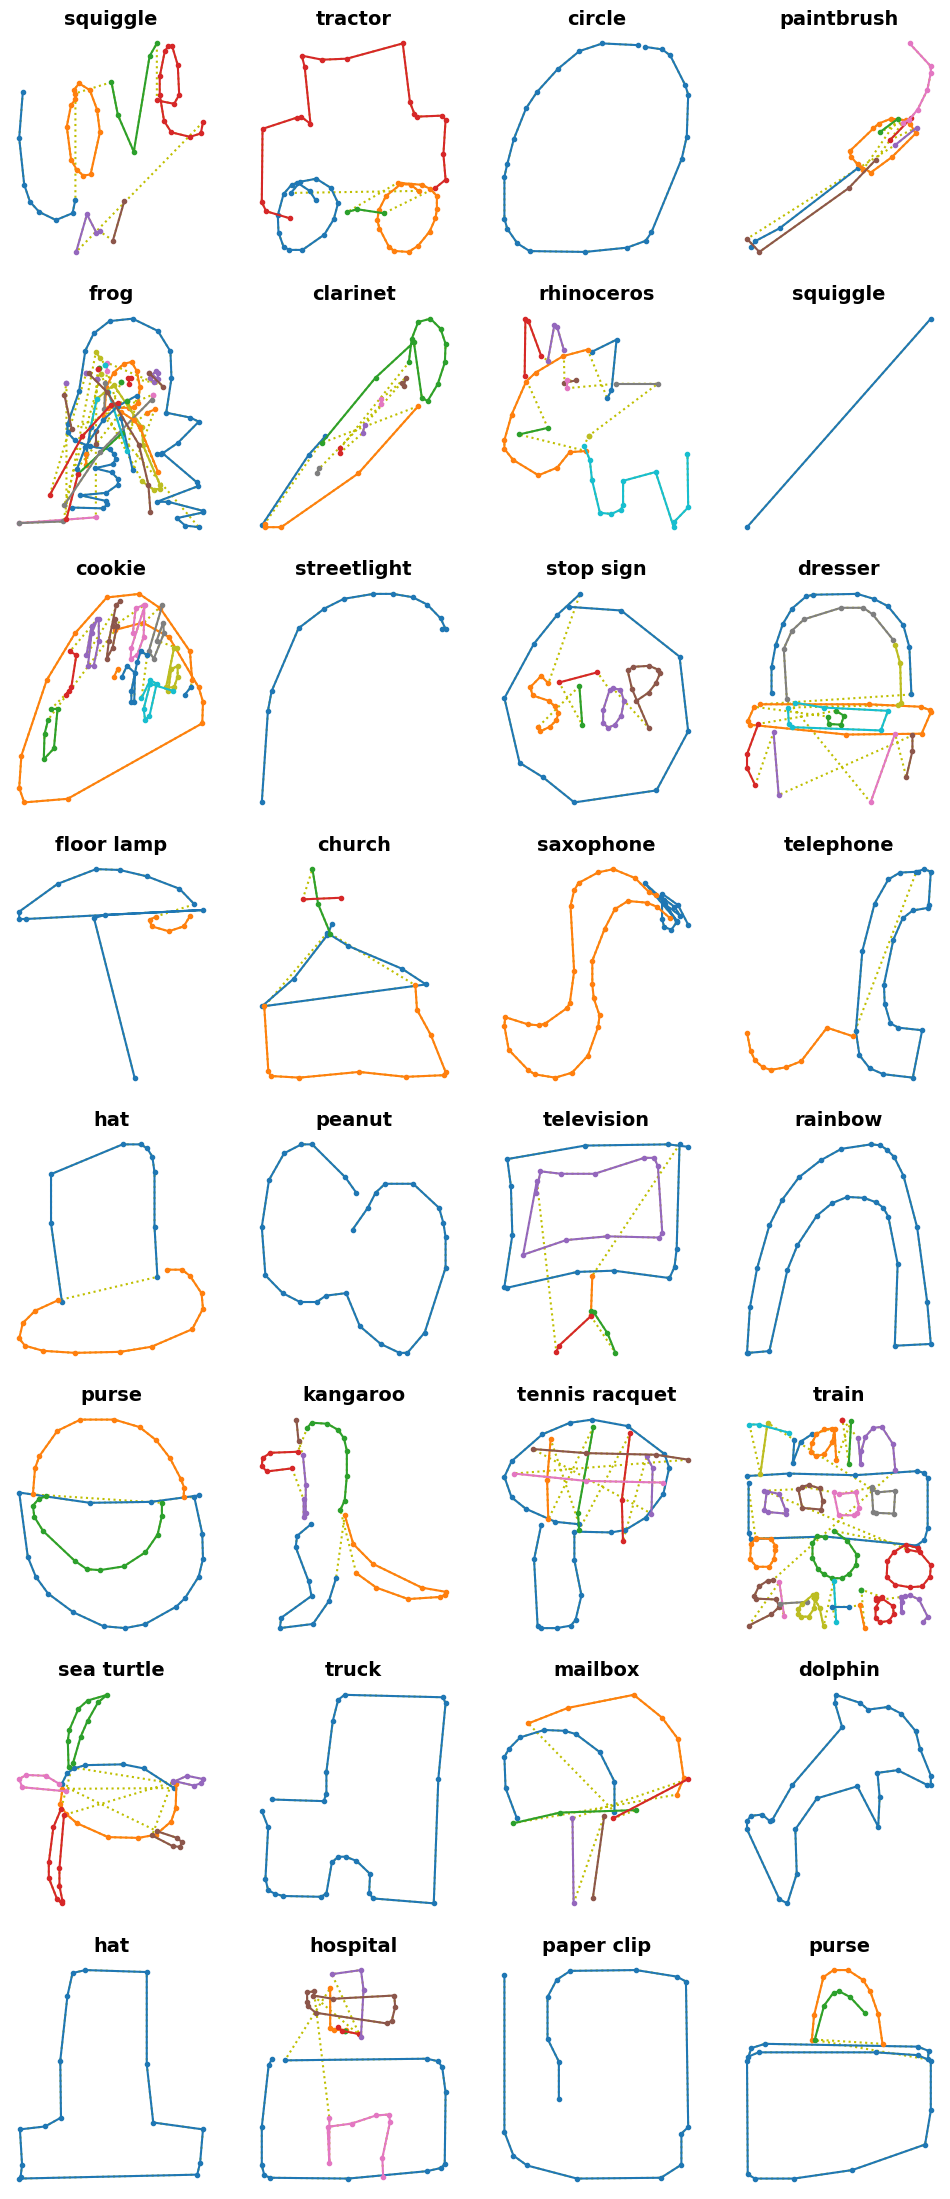

In [92]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

(array([1.37928650e-03, 5.93715431e-03, 1.32743363e-02, 1.95589049e-02,
        2.10885647e-02, 2.04352185e-02, 1.79410951e-02, 1.50580752e-02,
        1.24187638e-02, 9.49426162e-03, 7.22829093e-03, 5.05047013e-03,
        4.02378319e-03, 3.09043142e-03, 2.08967091e-03, 1.73707135e-03,
        1.29632190e-03, 9.95575221e-04, 6.37790376e-04, 5.75566925e-04,
        3.78525996e-04, 4.04452434e-04, 2.43708518e-04, 2.12596792e-04,
        2.28152655e-04, 1.76299779e-04, 1.29632190e-04, 8.81498894e-05,
        9.33351770e-05, 5.18528761e-05, 8.29646018e-05, 5.70381637e-05,
        4.14823009e-05, 2.59264381e-05, 2.59264381e-05, 2.59264381e-05,
        4.14823009e-05, 1.55558628e-05, 1.55558628e-05, 2.59264381e-05,
        2.07411504e-05, 1.03705752e-05, 2.07411504e-05, 1.55558628e-05,
        1.03705752e-05, 1.55558628e-05, 5.18528761e-06, 1.55558628e-05,
        0.00000000e+00, 5.18528761e-06, 1.03705752e-05, 5.18528761e-06,
        1.55558628e-05, 1.03705752e-05, 5.18528761e-06, 0.000000

(0.0, 200.0, 0.0, 0.03)

Text(0.5, 0, 'length')

Text(0, 0.5, 'density')

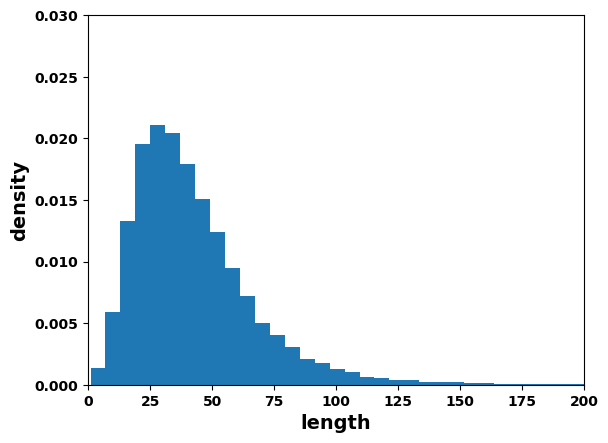

In [93]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [94]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [95]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
  23763/Unknown - 843s 35ms/step - loss: 5.3587 - accuracy: 0.0255 - sparse_top_k_categorical_accuracy: 0.0901

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [96]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [97]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [98]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [99]:
model.save("my_sketchrnn", save_format="tf")

## 10. Bach Chorales
_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [100]:
tf.keras.utils.get_file(
    "jsb_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True)

In [101]:
jsb_chorales_dir = Path("datasets/jsb_chorales")
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [102]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [103]:
train_chorales[0]

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [104]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [105]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = (note_duration * frequencies).round() / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [106]:
for index in range(3):
    play_chords(train_chorales[index])

Divine! :)

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [107]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [108]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [109]:
n_embedding_dims = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    tf.keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Now we're ready to compile and train the model!

In [110]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [111]:
model.save("my_bach_model", save_format="tf")
model.evaluate(test_set)

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

In [112]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note = model.predict(arpegio, verbose=0).argmax(axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [113]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [114]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [115]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [116]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [117]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [118]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [119]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")